# Investigating CW Attack Variants Using Diversity Promoting Regularization

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import datetime
import glob
import os

import pickle

import pandas as pd

%matplotlib inline

%load_ext autoreload
%autoreload 2

# check if CUDA is available
device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device = torch.device("cuda")
else:
    print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [15]:
n_epochs = 10
learning_rate = 0.01
momentum = 0.5

random_seed = 1
torch.manual_seed(random_seed)

In [70]:
data_dir = 'C:\data\CIFAR10'

batch_size_train = 64
batch_size_test = 100

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# PGD - 8/255    
    
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root=data_dir, train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        # normalize,
        transforms.ToTensor() 
    ]), download=True),
    batch_size=batch_size_train, shuffle=True,
    num_workers=2, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root=data_dir, train=False, transform=transforms.Compose([
        # normalize,
        transforms.ToTensor()    
    ])),
    batch_size=batch_size_test, shuffle=False,
    num_workers=2, pin_memory=True)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# targets = true labels only for when you're doing a targeted attack
# otherwise, you're going to make the inputs easier to classify to 
# do a targeted attack, targets should be some class other than
# the true label

inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

Files already downloaded and verified


# Loading a Pretrained ResNet56
https://github.com/akamaster/pytorch_resnet_cifar10

In [56]:
from resnet import *

models_dir = 'pretrained_models/cifar10/' 
model = resnet56().cuda()
state_dict = torch.load(models_dir + 'resnet56.th', map_location='cuda')['state_dict'] # best_prec1, state_dict

new_state_dict = {}

for k, v in state_dict.items():
    if 'module' in k:
        k = k.replace('module.', '')
    new_state_dict[k]=v
    
model.load_state_dict(new_state_dict)

Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Sequential
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
LambdaLayer
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
BasicBlock
Conv2d
Ba

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [57]:
# confirm that loading the weights actually worked
orig_output = model(inputs)
orig_pred = torch.argmax(orig_output, dim=1)
orig_correct = orig_pred.eq(targets.data).sum()
orig_acc = 100. * orig_correct / len(targets)
print('Accuracy: {}/{} ({:.0f}%)'.format(orig_correct, len(targets), orig_acc))

Accuracy: 10/100 (10%)


In [58]:
print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

)


In [59]:
layer_dict = {}
idx=0
for name, module in model.named_children():
    module.cuda()
    if (not isinstance(module, nn.Sequential)
        and not isinstance(module, nn.BatchNorm2d)):
        layer_dict[name + '-' + str(idx)] = module
        idx += 1
    else:
        for name_2, module_2 in module.named_children():
            module_2.cuda()
            for name_3, module_3 in module_2.named_children():
                module_3.cuda()
                if (not isinstance(module_3, nn.Sequential)
                    and not isinstance(module_3, nn.BatchNorm2d)
                    and 'shortcut' not in name_3):
                    layer_dict[name_3 + '-' + str(idx)] = module_3
                    idx += 1
                    
layer_dict
# layer_dict['conv1-0']

{'conv1-0': Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-1': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-2': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-3': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-4': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-5': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-6': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-7': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-8': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv1-9': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 'conv2-10': Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),

# Attempting to use a Pretrained DenseNet

In [60]:
# from densenet import *

# model = densenet()
# state_dict = torch.load(models_dir + 'DenseNet-BC-100-12.pth', map_location='cpu')['state_dict'] # acc, epoch, state_dict

# new_state_dict = OrderedDict()

# for k, v in state_dict.items():
#     if 'module' in k:
#         k = k.replace('module.', '')
#     new_state_dict[k]=v
    
# model.load_state_dict(new_state_dict)

# Train

In [61]:
# retrain = False
# track_low_high = False

# model = ConvNet().to(device)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# # check to see if we can just load a previous model
# models_dir = 'pretrained_models/cifar10/'
# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)
    
# latest_model = None
# m_type = model.__class__.__name__
# prev_models = glob.glob(models_dir + '*' + m_type + '*.pth')
# if prev_models:
#     latest_model = max(prev_models, key=os.path.getctime)

# if (retrain is False 
#     and latest_model is not None 
#     and m_type in latest_model):  
#     print('loading model', latest_model)
#     model.load_state_dict(torch.load(latest_model))  
# else:
#     if track_low_high:
#         model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
#         try:
#             for epoch in range(1, n_epochs + 1):
#                 model.hook_lowhigh_dict('relu')
#                 train(model, device, train_loader, optimizer, epoch)
#                 model.remove_hooks()
#                 test(model, device, test_loader)    
#         finally:
#             model.remove_hooks()   
#     else:
#         for epoch in range(1, n_epochs + 1):
#             train(model, device, train_loader, optimizer, epoch)
#             acc = test(model, device, test_loader)  
#     torch.save(model.state_dict(), models_dir + 'model_' + m_type + '_' + str(datetime.datetime.now()).replace(':','.') + '_' + str(acc) + '.pth')

# Helper Methods

In [62]:
def atanh(x, eps=1e-2):
    """
    The inverse hyperbolic tangent function, missing in pytorch.

    :param x: a tensor or a Variable
    :param eps: used to enhance numeric stability
    :return: :math:`\\tanh^{-1}{x}`, of the same type as ``x``
    """
    x = x * (1 - eps)
    return 0.5 * torch.log((1.0 + x) / (1.0 - x))

def to_tanh_space(x, box=(-1., 1.)):
    """
    Convert a batch of tensors to tanh-space. This method complements the
    implementation of the change-of-variable trick in terms of tanh.

    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in tanh-space, of the same dimension;
             the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return atanh((x - _box_plus) / _box_mul)

def from_tanh_space(x, box=(-1., 1.)):
    """
    Convert a batch of tensors from tanh-space to oridinary image space.
    This method complements the implementation of the change-of-variable trick
    in terms of tanh.

    :param x: the batch of tensors, of dimension [B x C x H x W]
    :param box: a tuple of lower bound and upper bound of the box constraint
    :return: the batch of tensors in ordinary image space, of the same
             dimension; the returned tensor is on the same device as ``x``
    """
    _box_mul = (box[1] - box[0]) * 0.5
    _box_plus = (box[1] + box[0]) * 0.5
    return torch.tanh(x) * _box_mul + _box_plus
  
def compensate_confidence(outputs, targets):
    """
    Compensate for ``self.confidence`` and returns a new weighted sum
    vector.

    :param outputs: the weighted sum right before the last layer softmax
           normalization, of dimension [B x M]
    :type outputs: np.ndarray
    :param targets: either the attack targets or the real image labels,
           depending on whether or not ``self.targeted``, of dimension [B]
    :type targets: np.ndarray
    :return: the compensated weighted sum of dimension [B x M]
    :rtype: np.ndarray
    """
    outputs_comp = outputs.clone()
    rng = torch.range(start=0, end=targets.shape[0]-1, dtype=torch.long, device=device)
    # targets = targets.int()
    if targeted:
        # for each image $i$:
        # if targeted, `outputs[i, target_onehot]` should be larger than
        # `max(outputs[i, ~target_onehot])` by `self.confidence`
        outputs_comp[rng, targets] -= confidence
    else:
        # for each image $i$:
        # if not targeted, `max(outputs[i, ~target_onehot]` should be larger
        # than `outputs[i, target_onehot]` (the ground truth image labels)
        # by `self.confidence`
        outputs_comp[rng, targets] += confidence
    return outputs_comp
  
def attack_successful(prediction, target):
    """
    See whether the underlying attack is successful.
    """
    if targeted:
        return prediction == target
    else:
        return prediction != target
      
def norm_divergence(data, model, layer, neuron=None, regularizer_weight=None):
    """
    returns the kld between the activations of the specified layer and a uniform pdf
    """
    # extract layer activations as numpy array
    layer_activations = torch.squeeze(model.extract_outputs(data=data, layer=layer))
    
    # normalize over summation (to get a probability density)
    out_norm = torch.sum(layer_activations, 0)
    out_norm = out_norm / torch.sum(out_norm) + 1e-6 # F.softmax(out_norm, 1)

    # create uniform tensor
    uniform_tensor = torch.ones(out_norm.shape).to(device)

    # normalize over summation (to get a probability density)
    uni_norm = uniform_tensor / torch.sum(uniform_tensor)
    
    # measure divergence between normalized layer activations and uniform distribution
    divergence = F.kl_div(input=out_norm.log(), target=uni_norm, reduction='sum')
    
    # default regularizer if not provided
    if regularizer_weight is None:
        regularizer_weight = 0.005 
    
    return regularizer_weight * divergence

def norm_divergence2(data, model, module, neuron=None, regularizer_weight=None):
    """
    returns the kld between the activations of the specified layer and a uniform pdf
    """
    data = torch.clamp(data, 0, 1)
    
    # extract layer activations as numpy array
    # NOTE: torch.relu is added just in case the layer is not actually ReLU'd beforehand
    #       This is required for the summation and KL-Divergence calculation, otherwise nan
    layer_activations = torch.relu(torch.squeeze(model.extract_outputs2(data=data, module=module)))
    
    # normalize over summation (to get a probability density)
    if len(layer_activations.size()) == 1:
        out_norm = (layer_activations / torch.sum(layer_activations)) + 1e-20 
    elif len(layer_activations.size()) == 2:
        out_norm = torch.sum(layer_activations, 0)
        out_norm = (out_norm / torch.sum(out_norm)) + 1e-20
    else:
        out_norm = (layer_activations / torch.sum(layer_activations)) + 1e-20 

    # create uniform tensor
    uniform_tensor = torch.ones(out_norm.shape).to(device)

    # normalize over summation (to get a probability density)
    uni_norm = uniform_tensor / torch.sum(uniform_tensor)
    
    # measure divergence between normalized layer activations and uniform distribution
    divergence = F.kl_div(input=out_norm.log(), target=uni_norm, reduction='sum')
    
    # default regularizer if not provided
    if regularizer_weight is None:
        regularizer_weight = 0.005 
        
    if divergence < 0:
        print(divergence, layer_activations, out_norm)
        torch.save(data, 'data.pt')
        torch.save(out_norm, 'out_norm.pt')
        torch.save(uni_norm, 'uni_norm.pt')
        return None
    
    return regularizer_weight * divergence

def eval_performance(model, originals, adversaries):
    pert_output = model(adversaries)
    orig_output = model(originals)

    pert_pred = torch.argmax(pert_output, dim=1)
    orig_pred = torch.argmax(orig_output, dim=1)

    pert_correct = pert_pred.eq(targets.data).sum()
    orig_correct = orig_pred.eq(targets.data).sum()

    pert_acc = 100. * pert_correct / len(targets)
    orig_acc = 100. * orig_correct / len(targets)

    print('Perturbed Accuracy: {}/{} ({:.0f}%)'.format(pert_correct, len(targets), pert_acc))
    print('Original Accuracy: {}/{} ({:.0f}%)'.format(orig_correct, len(targets), orig_acc))
    
    return pert_acc, orig_acc

def sample_images(originals, adversaries, num_samples = 5):
    orig_inputs = originals.cpu().detach().numpy()
    adv_examples = adversaries.cpu().detach().numpy()
    pert_output = model(adversaries)
    orig_output = model(originals)
    pert_pred = torch.argmax(pert_output, dim=1)
    orig_pred = torch.argmax(orig_output, dim=1)
    plt.figure(figsize=(15,8))
    for i in range(1, num_samples+1):
        plt.subplot(2, num_samples, i)
        plt.imshow(np.transpose(np.squeeze(orig_inputs[i]), (1, 2, 0)))  
        true_idx = targets[i].item()
        plt.title('true: {}'.format(classes[true_idx]))
        plt.xticks([])
        plt.yticks([])

        plt.subplot(2, num_samples, num_samples+i)
        plt.imshow(np.transpose(np.squeeze(adv_examples[i]), (1, 2, 0)))  
        pred_idx = pert_pred[i].item()
        orig_idx = orig_pred[i].item()
        plt.title('adv_pred: {} - orig_pred: {}'.format(classes[pred_idx], classes[orig_idx]))
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()

# Attack Time

| Version | Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - | - |
|  Baseline CW | CW |  True | L2 |  L2 |
|  Diversity v1 | CW |  True | Batch Divergence | Instance Divergence |
|  Diversity v2 | CW |  False | Batch Divergence | Instance Divergence |
|  Diversity v3 | Cross Entropy |  False | Batch Divergence | Instance Divergence |
|  Diversity v4 | CW |  True | Batch Divergence | L2 |

In [63]:
targeted=False
confidence=0.0
c_range=(1e-3, 1e10)
search_steps=10
max_steps=1000
abort_early=True
optimizer_lr=5e-4

mean = (0.485, 0.456, 0.406) # the mean used in inputs normalization
std = (0.229, 0.224, 0.225) # the standard deviation used in inputs normalization
box = (min((0 - m) / s for m, s in zip(mean, std)),
       max((1 - m) / s for m, s in zip(mean, std)))

log_frequency = 100

## Baseline CW

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  True | L2 | L2 |

In [64]:
def cw_l2_attack(model, inputs, targets, targeted=False, confidence=0.0,
                 c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                 abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                 init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # `lower_bounds`, `upper_bounds` and `scale_consts` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds < scale_consts <= upper_bounds
    lower_bounds = torch.tensor(np.zeros(batch_size), dtype=torch.float, device=device)
    upper_bounds = torch.tensor(np.ones(batch_size) * c_range[1], dtype=torch.float, device=device)
    scale_consts = torch.tensor(np.ones(batch_size) * c_range[0], dtype=torch.float, device=device)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_l2`          : the least L2 norms
    # - `o_best_l2_ppred`    : the perturbed predictions made by the adversarial perturbations with the least L2 norms
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_l2_ppred`
    o_best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    for const_step in range(search_steps):

        print('Step', const_step, scale_consts)

        # the minimum L2 norms of perturbations found during optimization
        best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

        # the perturbed predictions made by the adversarial perturbations with the least L2 norms
        best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

        # previous (summed) batch loss, to be used in early stopping policy
        prev_batch_loss = torch.tensor(np.inf, device=device)
        ae_tol = torch.tensor(1e-4, device=device)

        # optimization steps
        for optim_step in range(max_steps):

            adversaries = from_tanh_space(inputs_tanh + pert_tanh)
            pert_outputs = model(adversaries)

            # Calculate L2 norm between adversaries and original inputs
            pert_norms = torch.pow(adversaries - inputs, exponent=2)
            pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)

            target_activ = torch.sum(targets_oh * pert_outputs, 1)
            maxother_activ = torch.max(((1 - targets_oh) * pert_outputs - targets_oh * 1e4), 1)[0]

            if targeted:           
                # if targeted, optimize to make `target_activ` larger than `maxother_activ` by `confidence`
                f = torch.clamp(maxother_activ - target_activ + confidence, min=0.0)
            else:
                # if not targeted, optimize to make `maxother_activ` larger than `target_activ` (the ground truth image labels) by `confidence`
                f = torch.clamp(target_activ - maxother_activ + confidence, min=0.0)

            # the total loss of current batch, should be of dimension [1]
            l2_loss = torch.sum(pert_norms)
            cw_loss = torch.sum(scale_consts * f)
            batch_loss = cw_loss + l2_loss # torch.sum(pert_norms + scale_consts * f)

            # Do optimization for one step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            # "returns" batch_loss, pert_norms, pert_outputs, adversaries

            if optim_step % log_frequency == 0: 
                print('batch [{}] loss: {} cw_loss: {} l2_loss: {}'.format(optim_step, batch_loss, cw_loss, l2_loss))
                # print('pert_norms', pert_norms.size(), pert_norms)
                # print('target_activ', target_activ.size(), target_activ)
                # print('maxother_activ', maxother_activ.size(), maxother_activ)

            if abort_early and not optim_step % (max_steps // 10):   
                if batch_loss > prev_batch_loss * (1 - ae_tol):
                    break
                prev_batch_loss = batch_loss

            # update best attack found during optimization
            pert_predictions = torch.argmax(pert_outputs, dim=1)
            comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
            for i in range(batch_size):
                l2 = pert_norms[i]
                cppred = comp_pert_predictions[i]
                ppred = pert_predictions[i]
                tlabel = targets[i]
                ax = adversaries[i]
                if attack_successful(cppred, tlabel):
                    assert cppred == ppred
                    if l2 < best_l2[i]:
                        best_l2[i] = l2
                        best_l2_ppred[i] = ppred
                    if l2 < o_best_l2[i]:
                        o_best_l2[i] = l2
                        o_best_l2_ppred[i] = ppred
                        o_best_adversaries[i] = ax

        # binary search of `scale_const`
        for i in range(batch_size):
            tlabel = targets[i]
            if best_l2_ppred[i] != -1:
                # successful: attempt to lower `scale_const` by halving it
                if scale_consts[i] < upper_bounds[i]:
                    upper_bounds[i] = scale_consts[i]
                # `upper_bounds[i] == c_range[1]` implies no solution
                # found, i.e. upper_bounds[i] has never been updated by
                # scale_consts[i] until `scale_consts[i] > 0.1 * c_range[1]`
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
            else:
                # failure: multiply `scale_const` by ten if no solution
                # found; otherwise do binary search
                if scale_consts[i] > lower_bounds[i]:
                    lower_bounds[i] = scale_consts[i]
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
                else:
                    scale_consts[i] *= 10
                    
    return o_best_adversaries

In [ ]:
cw_advs = cw_l2_attack(model, inputs, targets, targeted=False, confidence=0.0,
                       c_range=(1e-3, 1e10), search_steps=3, max_steps=1000, 
                       abort_early=True, box=box, optimizer_lr=5e-4, 
                       init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs)
sample_images(inputs, cw_advs)

Step 0 tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010], device='cuda:0')
batch [0] loss: 9.885351181030273 cw_loss: 1.0567498207092285 l2_loss: 8.828601

In [ ]:
plt.imshow((cw_advs[1] - inputs[1]).cpu().detach().numpy().transpose(1,2,0)) 
plt.title(targets[1].cpu().numpy())
plt.show()

## Diversity Attack v1

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  True | L2, Batch Divergence | Instance Divergence |

In [10]:
def cw_div1_attack(model, module, regularizer_weight, inputs, targets, targeted=False, 
                   confidence=0.0, c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                   abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                   init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # `lower_bounds`, `upper_bounds` and `scale_consts` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds < scale_consts <= upper_bounds
    lower_bounds = torch.tensor(np.zeros(batch_size), dtype=torch.float, device=device)
    upper_bounds = torch.tensor(np.ones(batch_size) * c_range[1], dtype=torch.float, device=device)
    scale_consts = torch.tensor(np.ones(batch_size) * c_range[0], dtype=torch.float, device=device)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_div`         : the least divergences
    # - `o_best_div_ppred`   : the perturbed predictions made by the adversarial perturbations with the least divergences
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_div_ppred`
    o_best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    for const_step in range(search_steps):

        print('Step', const_step)

        # the minimum divergences of perturbations found during optimization
        best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

        # the perturbed predictions made by the adversarial perturbations with the least divergences
        best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

        # previous (summed) batch loss, to be used in early stopping policy
        prev_batch_loss = torch.tensor(np.inf, device=device)
        ae_tol = torch.tensor(1e-4, device=device)

        # optimization steps
        for optim_step in range(max_steps):

            adversaries = from_tanh_space(inputs_tanh + pert_tanh)
            pert_outputs = model(adversaries)
            
            # Calculate L2 norm between adversaries and original inputs
            pert_norms = torch.pow(adversaries - inputs, exponent=2)
            pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)

            # calculate kl divergence for each input to use for adversary selection
            divs = []
            for i in range(batch_size):
                divs.append(norm_divergence2(data=adversaries[i].unsqueeze(0), model=model, module=module, regularizer_weight=regularizer_weight)) 
            div_norms = torch.tensor(torch.stack(divs), device=device)
            
            # calculate kl divergence for batch to use in loss function
            div_reg = norm_divergence2(data=adversaries, model=model, module=module, regularizer_weight=regularizer_weight)

            target_activ = torch.sum(targets_oh * pert_outputs, 1)
            maxother_activ = torch.max(((1 - targets_oh) * pert_outputs - targets_oh * 1e4), 1)[0]

            if targeted:           
                # if targeted, optimize to make `target_activ` larger than `maxother_activ` by `confidence`
                f = torch.clamp(maxother_activ - target_activ + confidence, min=0.0)
            else:
                # if not targeted, optimize to make `maxother_activ` larger than `target_activ` (the ground truth image labels) by `confidence`
                f = torch.clamp(target_activ - maxother_activ + confidence, min=0.0)

            # the total loss of current batch, should be of dimension [1]
            L2_loss = torch.sum(pert_norms)
            cw_loss = torch.sum(scale_consts * f)
            
            batch_loss = cw_loss + L2_loss + div_reg

            # Do optimization for one step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            # "returns" batch_loss, pert_norms, pert_outputs, adversaries

            if optim_step % log_frequency == 0: 
                print('batch [{}] loss: {} cw_loss: {} L2_loss: {} div_reg: {}'.format(optim_step, batch_loss, cw_loss, L2_loss, div_reg))

            if abort_early and not optim_step % (max_steps // 10):   
                if batch_loss > prev_batch_loss * (1 - ae_tol):
                    break
                if batch_loss == 0:
                    break
                prev_batch_loss = batch_loss

            # update best attack found during optimization
            pert_predictions = torch.argmax(pert_outputs, dim=1)
            comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
            for i in range(batch_size):
                div = div_norms[i]
                cppred = comp_pert_predictions[i]
                ppred = pert_predictions[i]
                tlabel = targets[i]
                ax = adversaries[i]
                if attack_successful(cppred, tlabel):
                    assert cppred == ppred
                    if div < best_div[i]:
                        best_div[i] = div
                        best_div_ppred[i] = ppred
                    if div < o_best_div[i]:
                        o_best_div[i] = div
                        o_best_div_ppred[i] = ppred
                        o_best_adversaries[i] = ax

        # binary search of `scale_const`
        for i in range(batch_size):
            tlabel = targets[i]
            if best_div_ppred[i] != -1:
                # successful: attempt to lower `scale_const` by halving it
                if scale_consts[i] < upper_bounds[i]:
                    upper_bounds[i] = scale_consts[i]
                # `upper_bounds[i] == c_range[1]` implies no solution
                # found, i.e. upper_bounds[i] has never been updated by
                # scale_consts[i] until `scale_consts[i] > 0.1 * c_range[1]`
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
            else:
                # failure: multiply `scale_const` by ten if no solution
                # found; otherwise do binary search
                if scale_consts[i] > lower_bounds[i]:
                    lower_bounds[i] = scale_consts[i]
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
                else:
                    scale_consts[i] *= 10
                    
    return o_best_adversaries, div_norms

In [12]:
cw_advs_div1, div_norms1 = cw_div1_attack(model, layer_dict['conv1-0'], 1, inputs, targets, targeted=False, confidence=0.0,
                                          c_range=(1e-3, 1e10), search_steps=1, max_steps=1000, 
                                          abort_early=True, box=box, optimizer_lr=5e-4, 
                                          init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div1)
sample_images(inputs, cw_advs_div1)

Step 0
batch [0] loss: 28.532894134521484


KeyboardInterrupt: 

## Diversity Attack v2

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
|  CW |  False | L2, Batch Divergence | Instance Divergence |

In [11]:
def cw_div2_attack(model, module, regularizer_weight, inputs, targets, targeted=False, 
                   confidence=0.0, c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                   abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                   init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_div`         : the least divergences
    # - `o_best_div_ppred`   : the perturbed predictions made by the adversarial perturbations with the least divergences
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_div_ppred`
    o_best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    # the minimum divergences of perturbations found during optimization
    best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

    # the perturbed predictions made by the adversarial perturbations with the least divergences
    best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

    # previous (summed) batch loss, to be used in early stopping policy
    prev_batch_loss = torch.tensor(np.inf, device=device)
    ae_tol = torch.tensor(1e-4, device=device)

    # optimization steps
    for optim_step in range(max_steps):

        adversaries = from_tanh_space(inputs_tanh + pert_tanh)
        pert_outputs = model(adversaries)
        
        # Calculate L2 norm between adversaries and original inputs
        pert_norms = torch.pow(adversaries - inputs, exponent=2)
        pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)

        # calculate kl divergence for each input to use for adversary selection
        divs = []
        for i in range(batch_size):
            divs.append(norm_divergence2(data=adversaries[i].unsqueeze(0), model=model, module=module, regularizer_weight=regularizer_weight)) 
        div_norms = torch.tensor(torch.stack(divs), device=device)

        # calculate kl divergence for batch to use in loss function
        div_reg = norm_divergence2(data=adversaries, model=model, module=module, regularizer_weight=regularizer_weight)

        target_activ = torch.sum(targets_oh * pert_outputs, 1)
        maxother_activ = torch.max(((1 - targets_oh) * pert_outputs - targets_oh * 1e4), 1)[0]

        if targeted:           
            # if targeted, optimize to make `target_activ` larger than `maxother_activ` by `confidence`
            f = torch.clamp(maxother_activ - target_activ + confidence, min=0.0)
        else:
            # if not targeted, optimize to make `maxother_activ` larger than `target_activ` (the ground truth image labels) by `confidence`
            f = torch.clamp(target_activ - maxother_activ + confidence, min=0.0)

        # the total loss of current batch, should be of dimension [1]
        L2_loss = torch.sum(pert_norms)
        cw_loss = torch.sum(f)

        batch_loss = cw_loss + L2_loss + div_reg

        # Do optimization for one step
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # "returns" batch_loss, pert_norms, pert_outputs, adversaries

        if optim_step % log_frequency == 0: 
            print('batch [{}] loss: {} cw_loss: {} L2_loss: {} div_reg: {}'.format(optim_step, batch_loss, cw_loss, L2_loss, div_reg))

        if abort_early and not optim_step % (max_steps // 10):   
            if batch_loss > prev_batch_loss * (1 - ae_tol):
                break
            if batch_loss == 0:
                break
            prev_batch_loss = batch_loss

        # update best attack found during optimization
        pert_predictions = torch.argmax(pert_outputs, dim=1)
        comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
        for i in range(batch_size):
            div = div_norms[i]
            cppred = comp_pert_predictions[i]
            ppred = pert_predictions[i]
            tlabel = targets[i]
            ax = adversaries[i]
            if attack_successful(cppred, tlabel):
                assert cppred == ppred
                if div < best_div[i]:
                    best_div[i] = div
                    best_div_ppred[i] = ppred
                if div < o_best_div[i]:
                    o_best_div[i] = div
                    o_best_div_ppred[i] = ppred
                    o_best_adversaries[i] = ax
                    
    return o_best_adversaries, div_norms

In [14]:
# model = model.cpu()
# inputs = inputs.cpu()
# targets = targets.cpu()
# layer_dict['conv1-0'] = layer_dict['conv1-0'].cpu()

# device = torch.device('cpu')

cw_advs_div2, div_norms2 = cw_div2_attack(model, layer_dict['conv1-0'], 1, inputs, targets, targeted=False, confidence=0.0,
                                          c_range=(1e-3, 1e10), search_steps=1, max_steps=1000, 
                                          abort_early=True, box=box, optimizer_lr=5e-4, 
                                          init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div2)
sample_images(inputs, cw_advs_div2)

batch [0] loss: 1084.2259521484375


KeyboardInterrupt: 

## Diversity Attack v3

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
| Cross Entropy |  False | L2, Batch Divergence | Instance Divergence |

In [12]:
def cw_div3_attack(model, module, regularizer_weight, inputs, targets, targeted=False, 
                   confidence=0.0, c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                   abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                   init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_div`         : the least divergences
    # - `o_best_div_ppred`   : the perturbed predictions made by the adversarial perturbations with the least divergences
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_div_ppred`
    o_best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    # the minimum divergences of perturbations found during optimization
    best_div = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

    # the perturbed predictions made by the adversarial perturbations with the least divergences
    best_div_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

    # previous (summed) batch loss, to be used in early stopping policy
    prev_batch_loss = torch.tensor(np.inf, device=device)
    ae_tol = torch.tensor(1e-4, device=device)

    # optimization steps
    for optim_step in range(max_steps):

        adversaries = from_tanh_space(inputs_tanh + pert_tanh)
        pert_outputs = model(adversaries)
        
        # Calculate L2 norm between adversaries and original inputs
        pert_norms = torch.pow(adversaries - inputs, exponent=2)
        pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)

        # calculate kl divergence for each input to use for adversary selection
        divs = []
        for i in range(batch_size):
            divs.append(norm_divergence2(data=adversaries[i].unsqueeze(0), model=model, module=module, regularizer_weight=regularizer_weight)) 
        div_norms = torch.tensor(torch.stack(divs), device=device)

        # calculate kl divergence for batch to use in loss function
        div_reg = norm_divergence2(data=adversaries, model=model, module=module, regularizer_weight=regularizer_weight)

        loss = -1. * nn.CrossEntropyLoss()(pert_outputs, targets)

        # the total loss of current batch, should be of dimension [1]
        ce_loss = torch.sum(loss)
        L2_loss = torch.sum(pert_norms)
        
        batch_loss = ce_loss + L2_loss + div_reg

        # Do optimization for one step
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # "returns" batch_loss, pert_norms, pert_outputs, adversaries

        if optim_step % log_frequency == 0: 
            print('batch [{}] loss: {} ce_loss: {} L2_loss: {} div_reg: {}'.format(optim_step, batch_loss, ce_loss, L2_loss, div_reg))

        if abort_early and not optim_step % (max_steps // 10):   
            if batch_loss > prev_batch_loss * (1 - ae_tol):
                break
            if batch_loss == 0:
                break
            prev_batch_loss = batch_loss

        # update best attack found during optimization
        pert_predictions = torch.argmax(pert_outputs, dim=1)
        comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
        for i in range(batch_size):
            div = div_norms[i]
            cppred = comp_pert_predictions[i]
            ppred = pert_predictions[i]
            tlabel = targets[i]
            ax = adversaries[i]
            if attack_successful(cppred, tlabel):    
                assert cppred == ppred
                if div < best_div[i]:
                    best_div[i] = div
                    best_div_ppred[i] = ppred
                if div < o_best_div[i]:
                    o_best_div[i] = div
                    o_best_div_ppred[i] = ppred
                    o_best_adversaries[i] = ax
                    
    return o_best_adversaries, div_norms

In [16]:
cw_advs_div3, div_norms3 = cw_div3_attack(model, layer_dict['conv1-0'], 1, inputs, targets, targeted=False, confidence=0.0,
                                          c_range=(1e-3, 1e10), search_steps=1, max_steps=1000, 
                                          abort_early=True, box=box, optimizer_lr=5e-4, 
                                          init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div3)
sample_images(inputs, cw_advs_div3)

batch [0] loss: 27.13928985595703


KeyboardInterrupt: 

## Diversity Attack v4

| Loss Function | Scaling Constant | Regularizer | Adversary Selection |
| - | - | - | - |
| CW |  True | L2, Batch Divergence | L2 |

In [13]:
def cw_div4_attack(model, module, regularizer_weight, inputs, targets, targeted=False, 
                   confidence=0.0, c_range=(1e-3, 1e10), search_steps=5, max_steps=1000, 
                   abort_early=True, box=(-1., 1.), optimizer_lr=1e-2, 
                   init_rand=False, log_frequency=10):

    batch_size = inputs.size(0)
    num_classes = model(torch.tensor(inputs[0][None,:], requires_grad=False)).size(1)

    # `lower_bounds`, `upper_bounds` and `scale_consts` are used
    # for binary search of each `scale_const` in the batch. The element-wise
    # inquality holds: lower_bounds < scale_consts <= upper_bounds
    lower_bounds = torch.tensor(np.zeros(batch_size), dtype=torch.float, device=device)
    upper_bounds = torch.tensor(np.ones(batch_size) * c_range[1], dtype=torch.float, device=device)
    scale_consts = torch.tensor(np.ones(batch_size) * c_range[0], dtype=torch.float, device=device)

    # Optimal attack to be found.
    # The three "placeholders" are defined as:
    # - `o_best_l2`          : the least L2 norms
    # - `o_best_l2_ppred`    : the perturbed predictions made by the adversarial perturbations with the least L2 norms
    # - `o_best_adversaries` : the underlying adversarial example of `o_best_l2_ppred`
    o_best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)
    o_best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)
    o_best_adversaries = inputs.clone()

    # convert `inputs` to tanh-space
    inputs_tanh = to_tanh_space(inputs)
    targets_oh = F.one_hot(targets).float()

    # the perturbation tensor (only one we need to track gradients on)
    pert_tanh = torch.zeros(inputs.size(), device=device, requires_grad=True)

    optimizer = optim.Adam([pert_tanh], lr=optimizer_lr)

    for const_step in range(search_steps):

        print('Step', const_step)

        # the minimum L2 norms of perturbations found during optimization
        best_l2 = torch.tensor(np.ones(batch_size) * np.inf, dtype=torch.float, device=device)

        # the perturbed predictions made by the adversarial perturbations with the least L2 norms
        best_l2_ppred = torch.tensor(-np.ones(batch_size), dtype=torch.float, device=device)

        # previous (summed) batch loss, to be used in early stopping policy
        prev_batch_loss = torch.tensor(np.inf, device=device)
        ae_tol = torch.tensor(1e-4, device=device) # abort early tolerance

        # optimization steps
        for optim_step in range(max_steps):

            adversaries = from_tanh_space(inputs_tanh + pert_tanh)
            pert_outputs = model(adversaries)

            # Calculate L2 norm between adversaries and original inputs to use for adversary selection
            pert_norms = torch.pow(adversaries - inputs, exponent=2)
            pert_norms = torch.sum(pert_norms.view(pert_norms.size(0), -1), 1)
            
            # calculate kl divergence for batch to use in loss function
            div_reg = norm_divergence2(data=adversaries, model=model, module=module, regularizer_weight=regularizer_weight)

            target_activ = torch.sum(targets_oh * pert_outputs, 1)
            maxother_activ = torch.max(((1 - targets_oh) * pert_outputs - targets_oh * 1e4), 1)[0]

            if targeted:           
                # if targeted, optimize to make `target_activ` larger than `maxother_activ` by `confidence`
                f = torch.clamp(maxother_activ - target_activ + confidence, min=0.0)
            else:
                # if not targeted, optimize to make `maxother_activ` larger than `target_activ` (the ground truth image labels) by `confidence`
                f = torch.clamp(target_activ - maxother_activ + confidence, min=0.0)

            cw_loss = torch.sum(scale_consts * f)
            L2_loss = torch.sum(pert_norms)
            
            batch_loss = cw_loss + div_reg

            # Do optimization for one step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            # "returns" batch_loss, pert_norms, pert_outputs, adversaries

            if optim_step % log_frequency == 0: 
                print('batch [{}] loss: {} cw_loss: {} L2_loss: {} div_reg: {}'.format(optim_step, batch_loss, cw_loss, L2_loss, div_reg))

            if abort_early and not optim_step % (max_steps // 10):
                if batch_loss > prev_batch_loss * (1 - ae_tol):
                    break
                if batch_loss == 0:
                    break
                prev_batch_loss = batch_loss

            # update best attack found during optimization
            pert_predictions = torch.argmax(pert_outputs, dim=1)
            comp_pert_predictions = torch.argmax(compensate_confidence(pert_outputs, targets), dim=1)
            for i in range(batch_size):
                l2 = pert_norms[i]
                cppred = comp_pert_predictions[i]
                ppred = pert_predictions[i]
                tlabel = targets[i]
                ax = adversaries[i]
                if attack_successful(cppred, tlabel):
                    assert cppred == ppred
                    if l2 < best_l2[i]:
                        best_l2[i] = l2
                        best_l2_ppred[i] = ppred
                    if l2 < o_best_l2[i]:
                        o_best_l2[i] = l2
                        o_best_l2_ppred[i] = ppred
                        o_best_adversaries[i] = ax

        # binary search of `scale_const`
        for i in range(batch_size):
            tlabel = targets[i]
            if best_l2_ppred[i] != -1:
                # successful: attempt to lower `scale_const` by halving it
                if scale_consts[i] < upper_bounds[i]:
                    upper_bounds[i] = scale_consts[i]
                # `upper_bounds[i] == c_range[1]` implies no solution
                # found, i.e. upper_bounds[i] has never been updated by
                # scale_consts[i] until `scale_consts[i] > 0.1 * c_range[1]`
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
            else:
                # failure: multiply `scale_const` by ten if no solution
                # found; otherwise do binary search
                if scale_consts[i] > lower_bounds[i]:
                    lower_bounds[i] = scale_consts[i]
                if upper_bounds[i] < c_range[1] * 0.1:
                    scale_consts[i] = (lower_bounds[i] + upper_bounds[i]) / 2
                else:
                    scale_consts[i] *= 10
                    
    return o_best_adversaries, pert_norms

In [18]:
cw_advs_div4, l2_norms4 = cw_div4_attack(model, layer_dict['conv1-0'], 1, inputs, targets, targeted=False, confidence=0.,
                                         c_range=(1e-3, 1e10), search_steps=3, max_steps=1000, 
                                         abort_early=True, box=box, optimizer_lr=5e-4, 
                                         init_rand=False, log_frequency=100)

eval_performance(model, inputs, cw_advs_div4)
sample_images(inputs, cw_advs_div4)

Step 0
batch [0] loss: 28.532894134521484 cw_loss: 9.885351181030273 div_reg: 18.64754295349121


KeyboardInterrupt: 

# Evaluation

In [1]:
# target_layers = list(layer_dict)[0::11]
# for layer_idx in target_layers:
#     module = layer_dict[layer_idx]
#     print(layer_idx, module)

timestamp 2019-08-04 22.35.06.941707 attack cw_div4_attack layer:  conv1-0 regularization_weight:  0 confidence:  0
Step 0
batch [0] loss: 1.0567498207092285 cw_loss: 1.0567498207092285 L2_loss: 8.828601837158203 div_reg: 0.0
batch [100] loss: 0.0 cw_loss: 0.0 L2_loss: 19.82769775390625 div_reg: 0.0
Step 1
batch [0] loss: 0.0 cw_loss: 0.0 L2_loss: 19.8279972076416 div_reg: 0.0
Step 2
batch [0] loss: 0.0 cw_loss: 0.0 L2_loss: 19.828269958496094 div_reg: 0.0
Perturbed Accuracy: 32/100 (32%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


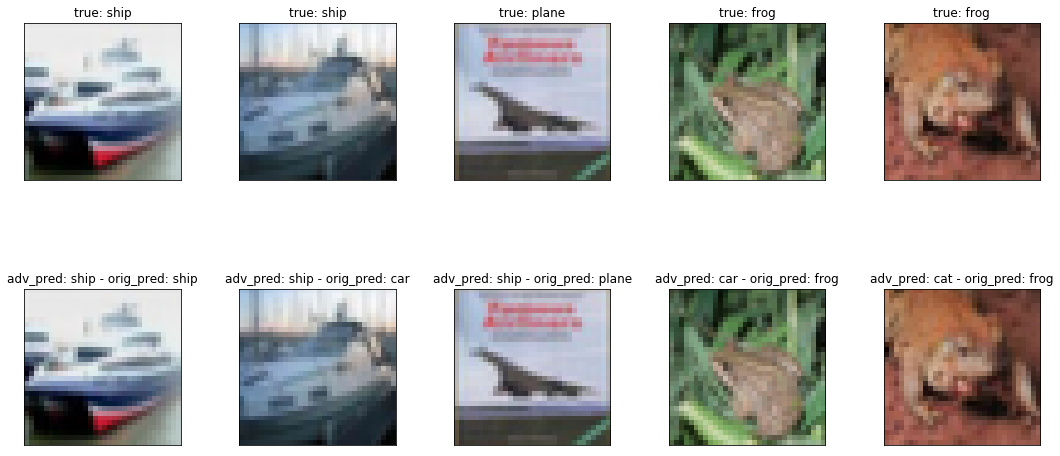

timestamp 2019-08-04 22.35.25.791237 attack cw_div4_attack layer:  conv1-0 regularization_weight:  0 confidence:  20
Step 0
batch [0] loss: 3.026632785797119 cw_loss: 3.026632785797119 L2_loss: 8.828601837158203 div_reg: 0.0
batch [100] loss: 0.006887150928378105 cw_loss: 0.006887150928378105 L2_loss: 40.6624755859375 div_reg: 0.0
batch [200] loss: 0.0 cw_loss: 0.0 L2_loss: 42.201507568359375 div_reg: 0.0
Step 1
batch [0] loss: 0.0 cw_loss: 0.0 L2_loss: 42.20256042480469 div_reg: 0.0
Step 2
batch [0] loss: 0.0 cw_loss: 0.0 L2_loss: 42.203529357910156 div_reg: 0.0
Perturbed Accuracy: 14/100 (14%)
Original Accuracy: 93/100 (93%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


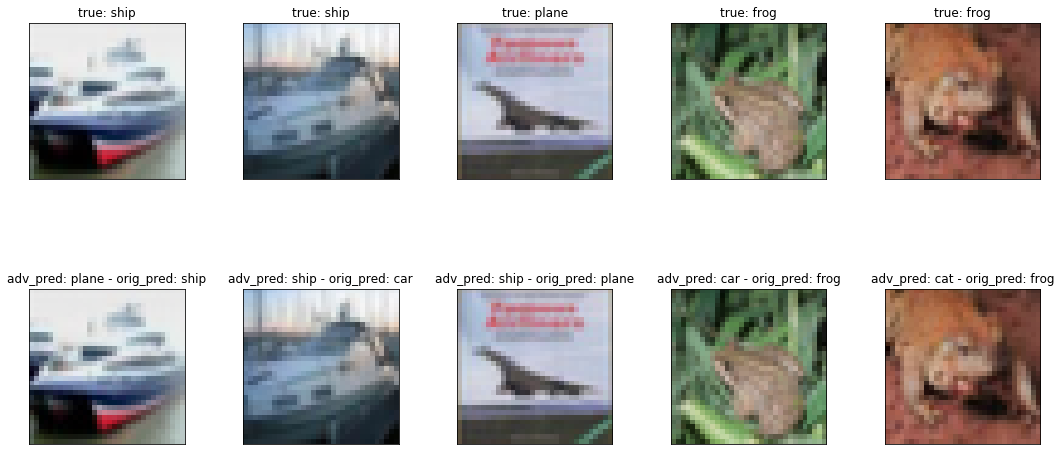

timestamp 2019-08-04 22.36.02.831180 attack cw_div4_attack layer:  conv1-0 regularization_weight:  0 confidence:  40
Step 0
batch [0] loss: 5.026633262634277 cw_loss: 5.026633262634277 L2_loss: 8.828601837158203 div_reg: 0.0
batch [100] loss: 1.3094902038574219 cw_loss: 1.3094902038574219 L2_loss: 65.62479400634766 div_reg: 0.0
batch [200] loss: 0.9764268398284912 cw_loss: 0.9764268398284912 L2_loss: 118.4312744140625 div_reg: 0.0


KeyboardInterrupt: 

In [15]:
results = []

attack_versions = [cw_div4_attack] # [cw_div1_attack, cw_div2_attack, cw_div3_attack, cw_div4_attack]

# every nth layer
n = 11
target_layers = list(layer_dict)[0::n]

reg_weights = [0, 0.01, 1, 10]
confidences = [0, 20, 40]


for attack in attack_versions:
    for layer_idx in target_layers:
        module = layer_dict[layer_idx]
        for rw in reg_weights:
            for c in confidences:
                timestamp = str(datetime.datetime.now()).replace(':','.')
                print('timestamp', timestamp, 'attack', attack.__name__, 'layer: ', layer_idx, 'regularization_weight: ', rw, 'confidence: ', c)
                cw_advs_divs, divergences = attack(model, module, rw, inputs, targets, targeted=False, confidence=c,
                                                   c_range=(1e-3, 1e10), search_steps=3, max_steps=1000, 
                                                   abort_early=True, box=box, optimizer_lr=5e-4, 
                                                   init_rand=False, log_frequency=100)

                pert_acc, orig_acc = eval_performance(model, inputs, cw_advs_divs)
                sample_images(inputs, cw_advs_divs)

                pert_acc = pert_acc.item() / 100.
                orig_acc = orig_acc.item() / 100.

                out = {'timestamp': timestamp, 'attack': attack.__name__, 'layer': layer_idx, 'regularization_weight': rw, 'confidence': c, 'adversaries': cw_advs_divs, 'divergences':divergences, 'pert_acc':pert_acc, 'orig_acc': orig_acc}
                results.append(out)

                pickle.dump(results, open( "assets/results_cifar10.pickle", "wb" ))

In [11]:
# load the results from file
with open('assets/results_cifar10_div4.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [10]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
df[['attack', 'layer', 'regularization_weight', 'confidence', 'orig_acc', 'pert_acc']]

,attack,layer,regularization_weight,confidence,orig_acc,pert_acc
0,cw_div4_attack,conv1-0,0.000,0,0.93,0.69
1,cw_div4_attack,conv1-0,0.000,20,0.93,0.13
2,cw_div4_attack,conv1-0,0.000,40,0.93,0.10
3,cw_div4_attack,conv1-0,0.001,0,0.93,0.61
4,cw_div4_attack,conv1-0,0.001,20,0.93,0.12
5,cw_div4_attack,conv1-0,0.001,40,0.93,0.12
6,cw_div4_attack,conv1-0,0.010,0,0.93,0.64
7,cw_div4_attack,conv1-0,0.010,20,0.93,0.10
8,cw_div4_attack,conv1-0,0.010,40,0.93,0.11
9,cw_div4_attack,conv1-0,1.000,0,0.93,0.69


# Coverage Criteria

## Neuron Coverage (DeepXplore)

In [65]:
from tqdm import tqdm_notebook as tqdm

def get_model_modules(model):
    layer_dict = {}
    idx=0
    for name, module in model.named_children():
        module.cuda()
        if (not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.BatchNorm2d)):
            layer_dict[name + '-' + str(idx)] = module
            idx += 1
        else:
            for name_2, module_2 in module.named_children():
                module_2.cuda()
                for name_3, module_3 in module_2.named_children():
                    module_3.cuda()
                    if (not isinstance(module_3, nn.Sequential)
                        and not isinstance(module_3, nn.BatchNorm2d)
                        and 'shortcut' not in name_3):
                        layer_dict[name_3 + '-' + str(idx)] = module_3
                        idx += 1    
                        
    return layer_dict

def get_layer_output_sizes(model, data):   
    output_sizes = {}
    hooks = []  
    
    layer_dict = get_model_modules(model)
 
    def hook(module, input, output):
        module_idx = len(output_sizes)
        m_key = list(layer_dict)[module_idx]
        output_sizes[m_key] = list(output.size()[1:])      
    
    for name, module in layer_dict.items():
        hooks.append(module.register_forward_hook(hook))
    
    try:
        model(data[:1])  
    finally:
        for h in hooks:
            h.remove() 
    return output_sizes

def get_init_dict(model, data, init_value=False): 
    output_sizes = get_layer_output_sizes(model, data)       
    model_layer_dict = {}  
    for layer, output_size in output_sizes.items():
        for index in range(np.prod(output_size)):
            # since we only care about post-activation outputs
            model_layer_dict[(layer, index)] = init_value
    return model_layer_dict

def neurons_covered(model_layer_dict):
    covered_neurons = len([v for v in model_layer_dict.values() if v])
    total_neurons = len(model_layer_dict)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)

def scale(out, rmax=1, rmin=0):
    output_std = (out - out.min()) / (out.max() - out.min())
    output_scaled = output_std * (rmax - rmin) + rmin
    return output_scaled

def extract_outputs(model, data, module):
    outputs = []      
    def hook(module, input, output):
        outputs.append(torch.relu(output))   
    handle = module.register_forward_hook(hook)     
    model(data)
    handle.remove()
    return torch.stack(outputs)

def update_coverage(model, data, model_layer_dict, threshold=0.):   
    layer_dict = get_model_modules(model) 
    for layer, module in tqdm(layer_dict.items()): 
        outputs = torch.squeeze(torch.sum(extract_outputs(model, data, module), dim=1))
        scaled_outputs = scale(outputs)     
        for i, out in enumerate(scaled_outputs.view(-1)):
            if out > threshold:
                model_layer_dict[(layer, i)] = True
                
def eval_nc(model, data, threshold=0.):
    model_layer_dict = get_init_dict(model, data, False)
    update_coverage(model, data, model_layer_dict, threshold=0.)
    _, _, nc = neurons_covered(model_layer_dict)
    return nc

In [72]:
# test baseline (unperturbed) inputs
eval_nc(model, inputs, threshold=0.)

0.952470468928994

In [14]:
for i in range(len(results)):
    a = results[i]['attack'] 
    l = results[i]['layer']
    rw = results[i]['regularization_weight']
    nc = eval_nc(model, results[i]['adversaries'], threshold=0.)
    results[i]['neuron_coverage'] = nc
    print(i, a, l, rw, nc) 


0 cw_div4_attack conv1-0 0 0.9521681158331612



1 cw_div4_attack conv1-0 0 0.9520028545136998



2 cw_div4_attack conv1-0 0 0.9520310240567899



3 cw_div4_attack conv1-0 0.001 0.9522169430411839



4 cw_div4_attack conv1-0 0.001 0.9520122443613964



5 cw_div4_attack conv1-0 0.001 0.9520366579654078



6 cw_div4_attack conv1-0 0.01 0.9521361903509925



7 cw_div4_attack conv1-0 0.01 0.9520798512648125



8 cw_div4_attack conv1-0 0.01 0.9520948750211271



9 cw_div4_attack conv1-0 1 0.9521737497417792



10 cw_div4_attack conv1-0 1 0.9520141223309357



11 cw_div4_attack conv1-0 1 0.9520836072038912



12 cw_div4_attack conv1-0 10 0.9521343123814532



13 cw_div4_attack conv1-0 10 0.951931491671205



14 cw_div4_attack conv1-0 10 0.9520573156303405



15 cw_div4_attack conv1-0 100 0.9521681158331612



16 cw_div4_attack conv1-0 100 0.9519746849706098



17 cw_div4_attack conv1-0 100 0.9520685834475765



18 cw_div4_attack conv1-11 0 0.9521906514676332



19 cw_div4_attack conv1-11 0 0.9519803188792277



20 cw_div4_attack conv1-11 0 0.9520704614171158



21 cw_div4_attack conv1-11 0.001 0.9521831395894759



22 cw_div4_attack conv1-11 0.001 0.9520028545136998



23 cw_div4_attack conv1-11 0.001 0.9521136547165205



24 cw_div4_attack conv1-11 0.01 0.9522169430411839



25 cw_div4_attack conv1-11 0.01 0.9520066104527785



26 cw_div4_attack conv1-11 0.01 0.9520235121786325



27 cw_div4_attack conv1-11 1 0.9521512141073072



28 cw_div4_attack conv1-11 1 0.9519915866964638



29 cw_div4_attack conv1-11 1 0.9520948750211271



30 cw_div4_attack conv1-11 10 0.9522150650716446



31 cw_div4_attack conv1-11 10 0.9521249225337565



32 cw_div4_attack conv1-11 10 0.9521718717722398



33 cw_div4_attack conv1-11 100 0.9519521493361378



34 cw_div4_attack conv1-11 100 0.9518958102499577



35 cw_div4_attack conv1-11 100 0.9519784409096884



36 cw_div4_attack conv2-22 0 0.9521756277113185



37 cw_div4_attack conv2-22 0 0.9519803188792277



38 cw_div4_attack conv2-22 0 0.9520779732952731



39 cw_div4_attack conv2-22 0.001 0.9521831395894759



40 cw_div4_attack conv2-22 0.001 0.9520648275084979



41 cw_div4_attack conv2-22 0.001 0.9520066104527785



42 cw_div4_attack conv2-22 0.01 0.9521418242596105



43 cw_div4_attack conv2-22 0.01 0.9519821968487671



44 cw_div4_attack conv2-22 0.01 0.9520798512648125



45 cw_div4_attack conv2-22 1 0.9521718717722398



46 cw_div4_attack conv2-22 1 0.9521606039550039



47 cw_div4_attack conv2-22 1 0.9521418242596105



48 cw_div4_attack conv2-22 10 0.9520873631429698



49 cw_div4_attack conv2-22 10 0.9519014441585757



50 cw_div4_attack conv2-22 10 0.9519202238539691



51 cw_div4_attack conv2-22 100 0.9514601213168322



52 cw_div4_attack conv2-22 100 0.9517267929914177



53 cw_div4_attack conv2-22 100 0.9518582508591711



54 cw_div4_attack conv1-33 0 0.9521249225337565



55 cw_div4_attack conv1-33 0 0.9520235121786325



56 cw_div4_attack conv1-33 0 0.9520516817217225



57 cw_div4_attack conv1-33 0.001 0.9521925294371725



58 cw_div4_attack conv1-33 0.001 0.9520272681177111



59 cw_div4_attack conv1-33 0.001 0.9520347799958685



60 cw_div4_attack conv1-33 0.01 0.9522075531934872



61 cw_div4_attack conv1-33 0.01 0.9520967529906665



62 cw_div4_attack conv1-33 0.01 0.9520779732952731



63 cw_div4_attack conv1-33 1 0.9521493361377679



64 cw_div4_attack conv1-33 1 0.9520929970515878



65 cw_div4_attack conv1-33 1 0.9521530920768465



66 cw_div4_attack conv1-33 10 0.9521699938027005



67 cw_div4_attack conv1-33 10 0.9521681158331612



68 cw_div4_attack conv1-33 10 0.9521286784728352



69 cw_div4_attack conv1-33 100 0.9521512141073072



70 cw_div4_attack conv1-33 100 0.9519183458844298



71 cw_div4_attack conv1-33 100 0.9521850175590152



72 cw_div4_attack conv2-44 0 0.9522075531934872



73 cw_div4_attack conv2-44 0 0.9519990985746212



74 cw_div4_attack conv2-44 0 0.9520291460872504



75 cw_div4_attack conv2-44 0.001 0.9521868955285545



76 cw_div4_attack conv2-44 0.001 0.9520197562395538



77 cw_div4_attack conv2-44 0.001 0.9520554376608011



78 cw_div4_attack conv2-44 0.01 0.9521305564423745



79 cw_div4_attack conv2-44 0.01 0.9520479257826439



80 cw_div4_attack conv2-44 0.01 0.9520892411125091



81 cw_div4_attack conv2-44 1 0.9522601363405886



82 cw_div4_attack conv2-44 1 0.9520610715694191



83 cw_div4_attack conv2-44 1 0.9522150650716446



84 cw_div4_attack conv2-44 10 0.9519934646660031



85 cw_div4_attack conv2-44 10 0.9520441698435651



86 cw_div4_attack conv2-44 10 0.9519502713665985



87 cw_div4_attack conv2-44 100 0.9512253751244155



88 cw_div4_attack conv2-44 100 0.9518150575597664



89 cw_div4_attack conv2-44 100 0.9515164604030123



90 cw_div4_attack linear-55 0 0.9522037972544085



91 cw_div4_attack linear-55 0 0.9519953426355424



92 cw_div4_attack linear-55 0 0.9520610715694191



93 cw_div4_attack linear-55 0.001 0.9521493361377679



94 cw_div4_attack linear-55 0.001 0.9520141223309357



95 cw_div4_attack linear-55 0.001 0.9520554376608011



96 cw_div4_attack linear-55 0.01 0.9521286784728352



97 cw_div4_attack linear-55 0.01 0.9520160003004752



98 cw_div4_attack linear-55 0.01 0.9520986309602059



99 cw_div4_attack linear-55 1 0.9521606039550039



100 cw_div4_attack linear-55 1 0.9520103663918571



101 cw_div4_attack linear-55 1 0.9520836072038912



102 cw_div4_attack linear-55 10 0.9521380683205318



103 cw_div4_attack linear-55 10 0.9521080208079025



104 cw_div4_attack linear-55 10 0.9521192886251385



105 cw_div4_attack linear-55 100 0.9522019192848692



106 cw_div4_attack linear-55 100 0.9520986309602059



107 cw_div4_attack linear-55 100 0.9521155326860599


In [15]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
df[['attack', 'layer', 'regularization_weight', 'orig_acc', 'pert_acc', 'neuron_coverage']]

,attack,layer,regularization_weight,orig_acc,pert_acc,neuron_coverage
0,cw_div4_attack,conv1-0,0.000,0.93,0.69,0.952168
1,cw_div4_attack,conv1-0,0.000,0.93,0.13,0.952003
2,cw_div4_attack,conv1-0,0.000,0.93,0.10,0.952031
3,cw_div4_attack,conv1-0,0.001,0.93,0.61,0.952217
4,cw_div4_attack,conv1-0,0.001,0.93,0.12,0.952012
5,cw_div4_attack,conv1-0,0.001,0.93,0.12,0.952037
6,cw_div4_attack,conv1-0,0.010,0.93,0.64,0.952136
7,cw_div4_attack,conv1-0,0.010,0.93,0.10,0.952080
8,cw_div4_attack,conv1-0,0.010,0.93,0.11,0.952095
9,cw_div4_attack,conv1-0,1.000,0.93,0.69,0.952174


In [16]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results_cifar10_div4.pickle", "wb" ))

## k-multisection Neuron Coverage (DeepGauge)

In [13]:
# model.init_dict(model.covered_dict, inputs, 'relu', False)
# model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
# print(len(model.covered_dict), len(model.lowhigh_dict))

In [9]:
# # move this to cpu because the GPU RAM probably isn't large enough to handle it 
# device = torch.device("cpu")
# model.to(device)

model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
model.hook_lowhigh_dict('relu')

lohi_batch_size = int(len(train_loader.dataset) / 10)

lowhigh_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
    batch_size=lohi_batch_size, shuffle=True, pin_memory=True)

for i, (lohi_inputs, _) in enumerate(lowhigh_loader):
    print('batch:', i)
    lohi_inputs = lohi_inputs.to(device)
    model(lohi_inputs)

model.remove_hooks()

# device = torch.device("cuda")

pickle.dump(model.lowhigh_dict, open( "assets/lowhigh_dict.pickle", "wb" ))

{('relu1', 0): {'low': 0, 'high': 0.17005696892738342},
 ('relu1', 1): {'low': 0, 'high': 0.2610016167163849},
 ('relu1', 2): {'low': 0, 'high': 0.3574622869491577},
 ('relu1', 3): {'low': 0, 'high': 0.4250221848487854},
 ('relu1', 4): {'low': 0, 'high': 0.4433531165122986},
 ('relu1', 5): {'low': 0, 'high': 0.42099499702453613},
 ('relu1', 6): {'low': 0, 'high': 0.3878710865974426},
 ('relu1', 7): {'low': 0, 'high': 0.4209814667701721},
 ('relu1', 8): {'low': 0, 'high': 0.42347657680511475},
 ('relu1', 9): {'low': 0, 'high': 0.40517371892929077},
 ('relu1', 10): {'low': 0, 'high': 0.7064920663833618},
 ('relu1', 11): {'low': 0, 'high': 0.8078417778015137},
 ('relu1', 12): {'low': 0, 'high': 0.6157643795013428},
 ('relu1', 13): {'low': 0, 'high': 0.47518014907836914},
 ('relu1', 14): {'low': 0, 'high': 0.3899363875389099},
 ('relu1', 15): {'low': 0, 'high': 0.3532407879829407},
 ('relu1', 16): {'low': 0, 'high': 0.3282723128795624},
 ('relu1', 17): {'low': 0, 'high': 0.3503431081771850

In [5]:
# load the results from file
with open('assets/lowhigh_dict.pickle', 'rb') as handle:
    model.lowhigh_dict = pickle.load(handle)

In [6]:
get_dict_for_layer(model.lowhigh_dict, 'relu3')

{('relu3', 0): {'low': 0, 'high': 4.8202948570251465},
 ('relu3', 1): {'low': 0, 'high': 4.82769775390625},
 ('relu3', 2): {'low': 0, 'high': 7.479001522064209},
 ('relu3', 3): {'low': 0, 'high': 8.612505912780762},
 ('relu3', 4): {'low': 0, 'high': 5.791659355163574},
 ('relu3', 5): {'low': 0, 'high': 7.655079364776611},
 ('relu3', 6): {'low': 0, 'high': 6.207518100738525},
 ('relu3', 7): {'low': 0, 'high': 7.808154582977295},
 ('relu3', 8): {'low': 0, 'high': 8.590152740478516},
 ('relu3', 9): {'low': 0, 'high': 2.782480001449585},
 ('relu3', 10): {'low': 0, 'high': 1.412194848060608},
 ('relu3', 11): {'low': 0, 'high': 6.954821586608887},
 ('relu3', 12): {'low': 0, 'high': 4.98781681060791},
 ('relu3', 13): {'low': 0, 'high': 1.674249291419983},
 ('relu3', 14): {'low': 0, 'high': 3.0363736152648926},
 ('relu3', 15): {'low': 0, 'high': 5.852689743041992},
 ('relu3', 16): {'low': 0, 'high': 7.916790962219238},
 ('relu3', 17): {'low': 0, 'high': 6.889847755432129},
 ('relu3', 18): {'lo

# Inception Scoring

In [46]:
# load the results from file
import pickle
with open('assets/backups/cw_advs.pickle', 'rb') as handle:
    cw_advs = pickle.load(handle)

In [5]:
from inception_score import *
# %load_ext autoreload
# %autoreload 2

In [6]:
def preprocess_for_is2(imgs):
    '''
    imgs : input expected to be a pytorch cuda tensor of images with a single dimension
    returns the input images as a 3D numpy array by replicating the single array 3 times
    '''
    adv_np = imgs.cpu().detach().numpy()
    adv_np = np.squeeze(adv_np)
    return adv_np

In [73]:
adv_3d = preprocess_for_is2(inputs)
mean_is, std_is = inception_score(adv_3d, cuda=True, batch_size=10, resize=True, splits=10)

In [74]:
mean_is

3.1673819478535234

In [23]:
for i in range(len(results)):
    a = results[i]['attack'] 
    l = results[i]['layer']
    rw = results[i]['regularization_weight']
    adv_3d = preprocess_for_is2(results[i]['adversaries'])
    mean_is, std_is = inception_score(adv_3d, cuda=True, batch_size=10, resize=True, splits=10)
    results[i]['inception_score'] = mean_is
    print(i, a, l, rw, mean_is) 

0 cw_div4_attack conv1-0 0 3.158419887480994
1 cw_div4_attack conv1-0 0 3.1460901719235594
2 cw_div4_attack conv1-0 0 3.1397660085826846
3 cw_div4_attack conv1-0 0.001 3.1576514587853026
4 cw_div4_attack conv1-0 0.001 3.1443246809501657
5 cw_div4_attack conv1-0 0.001 3.1398040378046006
6 cw_div4_attack conv1-0 0.01 3.1564457621574684
7 cw_div4_attack conv1-0 0.01 3.1452633765743574
8 cw_div4_attack conv1-0 0.01 3.1402214285940575
9 cw_div4_attack conv1-0 1 3.158081510473303
10 cw_div4_attack conv1-0 1 3.1451107333992367
11 cw_div4_attack conv1-0 1 3.1417290488924197
12 cw_div4_attack conv1-0 10 3.1530764901839428
13 cw_div4_attack conv1-0 10 3.146635988780827
14 cw_div4_attack conv1-0 10 3.1383634254745343
15 cw_div4_attack conv1-0 100 3.153134934910568
16 cw_div4_attack conv1-0 100 3.1374656559661096
17 cw_div4_attack conv1-0 100 3.132557603957867
18 cw_div4_attack conv1-11 0 3.156737852789618
19 cw_div4_attack conv1-11 0 3.14693188931357
20 cw_div4_attack conv1-11 0 3.142318779486421

In [11]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
df[['attack', 'layer', 'regularization_weight', 'orig_acc', 'pert_acc', 'inception_score']]

NameError: name 'pd' is not defined

In [25]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results_cifar10_div4.pickle", "wb" ))

In [20]:
# plt.imshow(adv_np[0].reshape(28, 28))
# plt.imshow(adv_3d[0].transpose((1,2,0)))

# Fréchet Inception Distance (FID) Scoring
https://github.com/mseitzer/pytorch-fid

In [10]:
from fid_score import calculate_fid_given_paths
from shutil import copy2, rmtree

In [21]:
# load the results from file
with open('assets/backups/results_cifar10_div4.pickle', 'rb') as handle:
    results = pickle.load(handle)

### FID w Dim = 2048 (default)

In order to make this work with the mere 100 adversaries generated for each attack configuration, I plan to duplicate the images so that there are enough of them for this dimensionality. NOTE: It is not yet clear if this is a valid way of doing this...

In [47]:
results = [{'adversaries':cw_advs}]

In [48]:
results[0]['adversaries']

tensor([[[[0.6196, 0.6232, 0.6473,  ..., 0.5372, 0.4940, 0.4551],
          [0.5954, 0.5940, 0.6224,  ..., 0.5331, 0.4903, 0.4666],
          [0.5928, 0.5911, 0.6202,  ..., 0.5451, 0.5087, 0.4708],
          ...,
          [0.2665, 0.1645, 0.1212,  ..., 0.1491, 0.0508, 0.1569],
          [0.2392, 0.1927, 0.1373,  ..., 0.1022, 0.1136, 0.0783],
          [0.2115, 0.2197, 0.1756,  ..., 0.0942, 0.1330, 0.0825]],

         [[0.4386, 0.4353, 0.4551,  ..., 0.3726, 0.3564, 0.3334],
          [0.4384, 0.4328, 0.4458,  ..., 0.3732, 0.3566, 0.3449],
          [0.4320, 0.4261, 0.4352,  ..., 0.3856, 0.3712, 0.3493],
          ...,
          [0.4861, 0.3919, 0.3443,  ..., 0.3804, 0.2507, 0.3333],
          [0.4551, 0.4008, 0.3332,  ..., 0.3219, 0.3214, 0.2510],
          [0.4196, 0.4120, 0.3482,  ..., 0.3020, 0.3291, 0.2630]],

         [[0.1922, 0.1841, 0.2005,  ..., 0.1410, 0.1409, 0.1295],
          [0.1995, 0.1583, 0.1758,  ..., 0.1212, 0.1258, 0.1332],
          [0.1848, 0.1284, 0.1413,  ..., 0

In [50]:
target_num = 2048

img_root = "C:/temp_imgs/cifar/"
img_dirs = ["real/", "fake/"]

# try:
#     if os.path.exists(img_root):
#         rmtree(img_root)
for i in range(len(results)):   
    for img_dir in img_dirs:
        target_dir = img_root + img_dir + str(i) + "/"
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)
        if "real/" in img_dir:
            for j, (img, lbl) in enumerate(zip(inputs, targets)):
                img_to_save = img.clone()
                filename = target_dir + "img_" + str(j) + "_" + str(lbl.item()) + ".png"
                torchvision.utils.save_image(img_to_save, filename)
            imgs = glob.glob(target_dir + "*.png")
            orig_imgs = imgs
            while len(imgs) < target_num:
                for img in orig_imgs:
                    copy2(img, img.replace('.png', '_' + str(j) + '.png'))
                    j += 1
                imgs = glob.glob(target_dir + "*.png")    
        if "fake/" in img_dir:
            for j, (img, lbl) in enumerate(zip(results[i]['adversaries'], targets)):
                img_to_save = img.clone()
                filename = target_dir + "img_" + str(j) + "_" + str(lbl.item()) + ".png"
                torchvision.utils.save_image(img_to_save, filename)
            imgs = glob.glob(target_dir + "*.png")
            orig_imgs = imgs
            while len(imgs) < target_num:
                for img in orig_imgs:
                    copy2(img, img.replace('.png', '_' + str(j) + '.png'))
                    j += 1
                imgs = glob.glob(target_dir + "*.png") 
# except:
#     rmtree(img_root)

In [51]:
img_root = "C:/temp_imgs/cifar/"
img_dirs = ["real/", "fake/"]

i=0
real_dir = img_root + "real/" + str(i) + "/"
fake_dir = img_root + "fake/" + str(i) + "/"
paths = [real_dir, fake_dir]
fid_value = calculate_fid_given_paths(paths, 64, '0', 2048)
print(fid_value)

starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.80it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.71it/s]


starting calculate_frechet_distance()...
1.2806393932587283


In [29]:
for i in range(len(results)):
    a = results[i]['attack'] 
    l = results[i]['layer']
    rw = results[i]['regularization_weight']
    # FID BLOCK
    real_dir = img_root + "real/" + str(i) + "/"
    fake_dir = img_root + "fake/" + str(i) + "/"
    paths = [real_dir, fake_dir]
    print(paths)
    fid_2048 = calculate_fid_given_paths(paths, 64, '0', 2048)
    results[i]['FID_score2048'] = fid_2048
    print(i, a, l, rw, fid_2048) 

['C:/temp_imgs/cifar/real/0/', 'C:/temp_imgs/cifar/fake/0/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:14<00:00,  3.20it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.74it/s]


starting calculate_frechet_distance()...
0 cw_div4_attack conv1-0 0 3.4810829420361955e-05
['C:/temp_imgs/cifar/real/1/', 'C:/temp_imgs/cifar/fake/1/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.05it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.74it/s]


starting calculate_frechet_distance()...
1 cw_div4_attack conv1-0 0 1.1058395891606758
['C:/temp_imgs/cifar/real/2/', 'C:/temp_imgs/cifar/fake/2/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.79it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.60it/s]


starting calculate_frechet_distance()...
2 cw_div4_attack conv1-0 0 1.280307354914403
['C:/temp_imgs/cifar/real/3/', 'C:/temp_imgs/cifar/fake/3/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.19it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.90it/s]


starting calculate_frechet_distance()...
3 cw_div4_attack conv1-0 0.001 1.2799646370174973
['C:/temp_imgs/cifar/real/4/', 'C:/temp_imgs/cifar/fake/4/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.51it/s]


starting calculate_frechet_distance()...
4 cw_div4_attack conv1-0 0.001 1.280854399336627
['C:/temp_imgs/cifar/real/5/', 'C:/temp_imgs/cifar/fake/5/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.26it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.61it/s]


starting calculate_frechet_distance()...
5 cw_div4_attack conv1-0 0.001 1.2806919269065296
['C:/temp_imgs/cifar/real/6/', 'C:/temp_imgs/cifar/fake/6/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.77it/s]


starting calculate_frechet_distance()...
6 cw_div4_attack conv1-0 0.01 1.2799379908095752
['C:/temp_imgs/cifar/real/7/', 'C:/temp_imgs/cifar/fake/7/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.79it/s]


starting calculate_frechet_distance()...
7 cw_div4_attack conv1-0 0.01 1.280489124030628
['C:/temp_imgs/cifar/real/8/', 'C:/temp_imgs/cifar/fake/8/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.26it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.77it/s]


starting calculate_frechet_distance()...
8 cw_div4_attack conv1-0 0.01 1.2804727974040073
['C:/temp_imgs/cifar/real/9/', 'C:/temp_imgs/cifar/fake/9/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.67it/s]


starting calculate_frechet_distance()...
9 cw_div4_attack conv1-0 1 1.2796506438657742
['C:/temp_imgs/cifar/real/10/', 'C:/temp_imgs/cifar/fake/10/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.26it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.47it/s]


starting calculate_frechet_distance()...
10 cw_div4_attack conv1-0 1 1.2805829110390266
['C:/temp_imgs/cifar/real/11/', 'C:/temp_imgs/cifar/fake/11/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.50it/s]


starting calculate_frechet_distance()...
11 cw_div4_attack conv1-0 1 1.2804506343925972
['C:/temp_imgs/cifar/real/12/', 'C:/temp_imgs/cifar/fake/12/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.49it/s]


starting calculate_frechet_distance()...
12 cw_div4_attack conv1-0 10 1.2797333427611135
['C:/temp_imgs/cifar/real/13/', 'C:/temp_imgs/cifar/fake/13/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.78it/s]


starting calculate_frechet_distance()...
13 cw_div4_attack conv1-0 10 1.280572934385738
['C:/temp_imgs/cifar/real/14/', 'C:/temp_imgs/cifar/fake/14/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.10it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.72it/s]


starting calculate_frechet_distance()...
14 cw_div4_attack conv1-0 10 1.2800995876308527
['C:/temp_imgs/cifar/real/15/', 'C:/temp_imgs/cifar/fake/15/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.64it/s]


starting calculate_frechet_distance()...
15 cw_div4_attack conv1-0 100 1.2800710466397396
['C:/temp_imgs/cifar/real/16/', 'C:/temp_imgs/cifar/fake/16/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.46it/s]


starting calculate_frechet_distance()...
16 cw_div4_attack conv1-0 100 1.2806964739854192
['C:/temp_imgs/cifar/real/17/', 'C:/temp_imgs/cifar/fake/17/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.57it/s]


starting calculate_frechet_distance()...
17 cw_div4_attack conv1-0 100 1.2803964162538206
['C:/temp_imgs/cifar/real/18/', 'C:/temp_imgs/cifar/fake/18/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  3.87it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.45it/s]


starting calculate_frechet_distance()...
18 cw_div4_attack conv1-11 0 1.2801532586977111
['C:/temp_imgs/cifar/real/19/', 'C:/temp_imgs/cifar/fake/19/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.68it/s]


starting calculate_frechet_distance()...
19 cw_div4_attack conv1-11 0 1.2805790796735477
['C:/temp_imgs/cifar/real/20/', 'C:/temp_imgs/cifar/fake/20/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]


starting calculate_frechet_distance()...
20 cw_div4_attack conv1-11 0 1.2806632125282769
['C:/temp_imgs/cifar/real/21/', 'C:/temp_imgs/cifar/fake/21/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.20it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.74it/s]


starting calculate_frechet_distance()...
21 cw_div4_attack conv1-11 0.001 1.280030033400676
['C:/temp_imgs/cifar/real/22/', 'C:/temp_imgs/cifar/fake/22/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.60it/s]


starting calculate_frechet_distance()...
22 cw_div4_attack conv1-11 0.001 1.2804624121246053
['C:/temp_imgs/cifar/real/23/', 'C:/temp_imgs/cifar/fake/23/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.22it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.45it/s]


starting calculate_frechet_distance()...
23 cw_div4_attack conv1-11 0.001 1.2806175914800817
['C:/temp_imgs/cifar/real/24/', 'C:/temp_imgs/cifar/fake/24/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.22it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.64it/s]


starting calculate_frechet_distance()...
24 cw_div4_attack conv1-11 0.01 1.2800912846881976
['C:/temp_imgs/cifar/real/25/', 'C:/temp_imgs/cifar/fake/25/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.55it/s]


starting calculate_frechet_distance()...
25 cw_div4_attack conv1-11 0.01 1.2808599848522624
['C:/temp_imgs/cifar/real/26/', 'C:/temp_imgs/cifar/fake/26/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.73it/s]


starting calculate_frechet_distance()...
26 cw_div4_attack conv1-11 0.01 1.2802812624441242
['C:/temp_imgs/cifar/real/27/', 'C:/temp_imgs/cifar/fake/27/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.66it/s]


starting calculate_frechet_distance()...
27 cw_div4_attack conv1-11 1 1.2802145905268785
['C:/temp_imgs/cifar/real/28/', 'C:/temp_imgs/cifar/fake/28/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.17it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.55it/s]


starting calculate_frechet_distance()...
28 cw_div4_attack conv1-11 1 1.2804415120666346
['C:/temp_imgs/cifar/real/29/', 'C:/temp_imgs/cifar/fake/29/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.20it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.51it/s]


starting calculate_frechet_distance()...
29 cw_div4_attack conv1-11 1 1.2802244766995892
['C:/temp_imgs/cifar/real/30/', 'C:/temp_imgs/cifar/fake/30/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.62it/s]


starting calculate_frechet_distance()...
30 cw_div4_attack conv1-11 10 1.2819493254711725
['C:/temp_imgs/cifar/real/31/', 'C:/temp_imgs/cifar/fake/31/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]


starting calculate_frechet_distance()...
31 cw_div4_attack conv1-11 10 1.2795969598263164
['C:/temp_imgs/cifar/real/32/', 'C:/temp_imgs/cifar/fake/32/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.58it/s]


starting calculate_frechet_distance()...
32 cw_div4_attack conv1-11 10 1.2799195558695096
['C:/temp_imgs/cifar/real/33/', 'C:/temp_imgs/cifar/fake/33/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.26it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.57it/s]


starting calculate_frechet_distance()...
33 cw_div4_attack conv1-11 100 1.2780635083119005
['C:/temp_imgs/cifar/real/34/', 'C:/temp_imgs/cifar/fake/34/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.59it/s]


starting calculate_frechet_distance()...
34 cw_div4_attack conv1-11 100 1.2745004901909258
['C:/temp_imgs/cifar/real/35/', 'C:/temp_imgs/cifar/fake/35/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.59it/s]


starting calculate_frechet_distance()...
35 cw_div4_attack conv1-11 100 1.28639674481628
['C:/temp_imgs/cifar/real/36/', 'C:/temp_imgs/cifar/fake/36/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.59it/s]


starting calculate_frechet_distance()...
36 cw_div4_attack conv2-22 0 1.2800579108449293
['C:/temp_imgs/cifar/real/37/', 'C:/temp_imgs/cifar/fake/37/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.22it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.67it/s]


starting calculate_frechet_distance()...
37 cw_div4_attack conv2-22 0 1.2809030459320523
['C:/temp_imgs/cifar/real/38/', 'C:/temp_imgs/cifar/fake/38/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.87it/s]


starting calculate_frechet_distance()...
38 cw_div4_attack conv2-22 0 1.280623142939905
['C:/temp_imgs/cifar/real/39/', 'C:/temp_imgs/cifar/fake/39/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.22it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.67it/s]


starting calculate_frechet_distance()...
39 cw_div4_attack conv2-22 0.001 1.2801762510641586
['C:/temp_imgs/cifar/real/40/', 'C:/temp_imgs/cifar/fake/40/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.57it/s]


starting calculate_frechet_distance()...
40 cw_div4_attack conv2-22 0.001 1.28088565958986
['C:/temp_imgs/cifar/real/41/', 'C:/temp_imgs/cifar/fake/41/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.20it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.58it/s]


starting calculate_frechet_distance()...
41 cw_div4_attack conv2-22 0.001 1.2805049852315806
['C:/temp_imgs/cifar/real/42/', 'C:/temp_imgs/cifar/fake/42/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.55it/s]


starting calculate_frechet_distance()...
42 cw_div4_attack conv2-22 0.01 1.2797416390524936
['C:/temp_imgs/cifar/real/43/', 'C:/temp_imgs/cifar/fake/43/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.20it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.62it/s]


starting calculate_frechet_distance()...
43 cw_div4_attack conv2-22 0.01 1.2805159678496834
['C:/temp_imgs/cifar/real/44/', 'C:/temp_imgs/cifar/fake/44/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.68it/s]


starting calculate_frechet_distance()...
44 cw_div4_attack conv2-22 0.01 1.2807631940904274
['C:/temp_imgs/cifar/real/45/', 'C:/temp_imgs/cifar/fake/45/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.64it/s]


starting calculate_frechet_distance()...
45 cw_div4_attack conv2-22 1 1.279581963174732
['C:/temp_imgs/cifar/real/46/', 'C:/temp_imgs/cifar/fake/46/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.77it/s]


starting calculate_frechet_distance()...
46 cw_div4_attack conv2-22 1 1.2803292132315458
['C:/temp_imgs/cifar/real/47/', 'C:/temp_imgs/cifar/fake/47/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.61it/s]


starting calculate_frechet_distance()...
47 cw_div4_attack conv2-22 1 1.2790850379471916
['C:/temp_imgs/cifar/real/48/', 'C:/temp_imgs/cifar/fake/48/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.85it/s]


starting calculate_frechet_distance()...
48 cw_div4_attack conv2-22 10 1.2797729489379046
['C:/temp_imgs/cifar/real/49/', 'C:/temp_imgs/cifar/fake/49/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.79it/s]


starting calculate_frechet_distance()...
49 cw_div4_attack conv2-22 10 1.283033988932564
['C:/temp_imgs/cifar/real/50/', 'C:/temp_imgs/cifar/fake/50/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.74it/s]


starting calculate_frechet_distance()...
50 cw_div4_attack conv2-22 10 1.281162395033096
['C:/temp_imgs/cifar/real/51/', 'C:/temp_imgs/cifar/fake/51/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.72it/s]


starting calculate_frechet_distance()...
51 cw_div4_attack conv2-22 100 1.2835564016275414
['C:/temp_imgs/cifar/real/52/', 'C:/temp_imgs/cifar/fake/52/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.63it/s]


starting calculate_frechet_distance()...
52 cw_div4_attack conv2-22 100 1.2795568859134114
['C:/temp_imgs/cifar/real/53/', 'C:/temp_imgs/cifar/fake/53/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.20it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.80it/s]


starting calculate_frechet_distance()...
53 cw_div4_attack conv2-22 100 1.282595036172554
['C:/temp_imgs/cifar/real/54/', 'C:/temp_imgs/cifar/fake/54/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.22it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.59it/s]


starting calculate_frechet_distance()...
54 cw_div4_attack conv1-33 0 1.2798815402210657
['C:/temp_imgs/cifar/real/55/', 'C:/temp_imgs/cifar/fake/55/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.72it/s]


starting calculate_frechet_distance()...
55 cw_div4_attack conv1-33 0 1.2805868355969545
['C:/temp_imgs/cifar/real/56/', 'C:/temp_imgs/cifar/fake/56/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.19it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.44it/s]


starting calculate_frechet_distance()...
56 cw_div4_attack conv1-33 0 1.2804985878769695
['C:/temp_imgs/cifar/real/57/', 'C:/temp_imgs/cifar/fake/57/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.26it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.60it/s]


starting calculate_frechet_distance()...
57 cw_div4_attack conv1-33 0.001 1.280113082632939
['C:/temp_imgs/cifar/real/58/', 'C:/temp_imgs/cifar/fake/58/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.57it/s]


starting calculate_frechet_distance()...
58 cw_div4_attack conv1-33 0.001 1.2804241080398064
['C:/temp_imgs/cifar/real/59/', 'C:/temp_imgs/cifar/fake/59/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.49it/s]


starting calculate_frechet_distance()...
59 cw_div4_attack conv1-33 0.001 1.2805145142535403
['C:/temp_imgs/cifar/real/60/', 'C:/temp_imgs/cifar/fake/60/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.66it/s]


starting calculate_frechet_distance()...
60 cw_div4_attack conv1-33 0.01 1.2802224286951835
['C:/temp_imgs/cifar/real/61/', 'C:/temp_imgs/cifar/fake/61/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.81it/s]


starting calculate_frechet_distance()...
61 cw_div4_attack conv1-33 0.01 1.2806921297778708
['C:/temp_imgs/cifar/real/62/', 'C:/temp_imgs/cifar/fake/62/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.11it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.62it/s]


starting calculate_frechet_distance()...
62 cw_div4_attack conv1-33 0.01 1.280661052695293
['C:/temp_imgs/cifar/real/63/', 'C:/temp_imgs/cifar/fake/63/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]


starting calculate_frechet_distance()...
63 cw_div4_attack conv1-33 1 1.2798750152349572
['C:/temp_imgs/cifar/real/64/', 'C:/temp_imgs/cifar/fake/64/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]


starting calculate_frechet_distance()...
64 cw_div4_attack conv1-33 1 1.2803451777014168
['C:/temp_imgs/cifar/real/65/', 'C:/temp_imgs/cifar/fake/65/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.70it/s]


starting calculate_frechet_distance()...
65 cw_div4_attack conv1-33 1 1.2801144100188695
['C:/temp_imgs/cifar/real/66/', 'C:/temp_imgs/cifar/fake/66/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]


starting calculate_frechet_distance()...
66 cw_div4_attack conv1-33 10 1.2800063953830456
['C:/temp_imgs/cifar/real/67/', 'C:/temp_imgs/cifar/fake/67/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.71it/s]


starting calculate_frechet_distance()...
67 cw_div4_attack conv1-33 10 1.2797879246454689
['C:/temp_imgs/cifar/real/68/', 'C:/temp_imgs/cifar/fake/68/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.61it/s]


starting calculate_frechet_distance()...
68 cw_div4_attack conv1-33 10 1.279974976568098
['C:/temp_imgs/cifar/real/69/', 'C:/temp_imgs/cifar/fake/69/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.59it/s]


starting calculate_frechet_distance()...
69 cw_div4_attack conv1-33 100 1.2667280691805476
['C:/temp_imgs/cifar/real/70/', 'C:/temp_imgs/cifar/fake/70/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.56it/s]


starting calculate_frechet_distance()...
70 cw_div4_attack conv1-33 100 1.2614027907532874
['C:/temp_imgs/cifar/real/71/', 'C:/temp_imgs/cifar/fake/71/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.22it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.59it/s]


starting calculate_frechet_distance()...
71 cw_div4_attack conv1-33 100 1.2693452445974933
['C:/temp_imgs/cifar/real/72/', 'C:/temp_imgs/cifar/fake/72/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.20it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.86it/s]


starting calculate_frechet_distance()...
72 cw_div4_attack conv2-44 0 1.2800536010944925
['C:/temp_imgs/cifar/real/73/', 'C:/temp_imgs/cifar/fake/73/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.26it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.89it/s]


starting calculate_frechet_distance()...
73 cw_div4_attack conv2-44 0 1.2808660213866676
['C:/temp_imgs/cifar/real/74/', 'C:/temp_imgs/cifar/fake/74/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.19it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.56it/s]


starting calculate_frechet_distance()...
74 cw_div4_attack conv2-44 0 1.2806729547568234
['C:/temp_imgs/cifar/real/75/', 'C:/temp_imgs/cifar/fake/75/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.58it/s]


starting calculate_frechet_distance()...
75 cw_div4_attack conv2-44 0.001 1.2802508182572703
['C:/temp_imgs/cifar/real/76/', 'C:/temp_imgs/cifar/fake/76/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.69it/s]


starting calculate_frechet_distance()...
76 cw_div4_attack conv2-44 0.001 1.2805214164355794
['C:/temp_imgs/cifar/real/77/', 'C:/temp_imgs/cifar/fake/77/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.51it/s]


starting calculate_frechet_distance()...
77 cw_div4_attack conv2-44 0.001 1.2805649387524098
['C:/temp_imgs/cifar/real/78/', 'C:/temp_imgs/cifar/fake/78/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.59it/s]


starting calculate_frechet_distance()...
78 cw_div4_attack conv2-44 0.01 1.2803735396346354
['C:/temp_imgs/cifar/real/79/', 'C:/temp_imgs/cifar/fake/79/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]


starting calculate_frechet_distance()...
79 cw_div4_attack conv2-44 0.01 1.2801016746262373
['C:/temp_imgs/cifar/real/80/', 'C:/temp_imgs/cifar/fake/80/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.20it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.64it/s]


starting calculate_frechet_distance()...
80 cw_div4_attack conv2-44 0.01 1.280498272518981
['C:/temp_imgs/cifar/real/81/', 'C:/temp_imgs/cifar/fake/81/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.70it/s]


starting calculate_frechet_distance()...
81 cw_div4_attack conv2-44 1 1.2797123190130584
['C:/temp_imgs/cifar/real/82/', 'C:/temp_imgs/cifar/fake/82/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.65it/s]


starting calculate_frechet_distance()...
82 cw_div4_attack conv2-44 1 1.280366687675898
['C:/temp_imgs/cifar/real/83/', 'C:/temp_imgs/cifar/fake/83/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.22it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.60it/s]


starting calculate_frechet_distance()...
83 cw_div4_attack conv2-44 1 1.2803220051793318
['C:/temp_imgs/cifar/real/84/', 'C:/temp_imgs/cifar/fake/84/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.72it/s]


starting calculate_frechet_distance()...
84 cw_div4_attack conv2-44 10 1.2808099736833096
['C:/temp_imgs/cifar/real/85/', 'C:/temp_imgs/cifar/fake/85/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.22it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.62it/s]


starting calculate_frechet_distance()...
85 cw_div4_attack conv2-44 10 1.2811348477981006
['C:/temp_imgs/cifar/real/86/', 'C:/temp_imgs/cifar/fake/86/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.64it/s]


starting calculate_frechet_distance()...
86 cw_div4_attack conv2-44 10 1.2795977787764272
['C:/temp_imgs/cifar/real/87/', 'C:/temp_imgs/cifar/fake/87/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.54it/s]


starting calculate_frechet_distance()...
87 cw_div4_attack conv2-44 100 1.2784252171170065
['C:/temp_imgs/cifar/real/88/', 'C:/temp_imgs/cifar/fake/88/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.53it/s]


starting calculate_frechet_distance()...
88 cw_div4_attack conv2-44 100 1.2694609381271864
['C:/temp_imgs/cifar/real/89/', 'C:/temp_imgs/cifar/fake/89/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.78it/s]


starting calculate_frechet_distance()...
89 cw_div4_attack conv2-44 100 1.269875110547936
['C:/temp_imgs/cifar/real/90/', 'C:/temp_imgs/cifar/fake/90/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.28it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.22it/s]


starting calculate_frechet_distance()...
90 cw_div4_attack linear-55 0 1.2802345317369195
['C:/temp_imgs/cifar/real/91/', 'C:/temp_imgs/cifar/fake/91/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.27it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.19it/s]


starting calculate_frechet_distance()...
91 cw_div4_attack linear-55 0 1.2805346819692027
['C:/temp_imgs/cifar/real/92/', 'C:/temp_imgs/cifar/fake/92/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting calculate_frechet_distance()...
92 cw_div4_attack linear-55 0 1.2807740788212127
['C:/temp_imgs/cifar/real/93/', 'C:/temp_imgs/cifar/fake/93/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting calculate_frechet_distance()...
93 cw_div4_attack linear-55 0.001 1.2801204851768024
['C:/temp_imgs/cifar/real/94/', 'C:/temp_imgs/cifar/fake/94/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.22it/s]


starting calculate_frechet_distance()...
94 cw_div4_attack linear-55 0.001 1.2807970107770137
['C:/temp_imgs/cifar/real/95/', 'C:/temp_imgs/cifar/fake/95/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.27it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.18it/s]


starting calculate_frechet_distance()...
95 cw_div4_attack linear-55 0.001 1.2805252940538647
['C:/temp_imgs/cifar/real/96/', 'C:/temp_imgs/cifar/fake/96/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.18it/s]


starting calculate_frechet_distance()...
96 cw_div4_attack linear-55 0.01 1.279750044518483
['C:/temp_imgs/cifar/real/97/', 'C:/temp_imgs/cifar/fake/97/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.20it/s]


starting calculate_frechet_distance()...
97 cw_div4_attack linear-55 0.01 1.2805468850211543
['C:/temp_imgs/cifar/real/98/', 'C:/temp_imgs/cifar/fake/98/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.85it/s]


starting calculate_frechet_distance()...
98 cw_div4_attack linear-55 0.01 1.280761282313983
['C:/temp_imgs/cifar/real/99/', 'C:/temp_imgs/cifar/fake/99/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.27it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.19it/s]


starting calculate_frechet_distance()...
99 cw_div4_attack linear-55 1 1.2799137967188872
['C:/temp_imgs/cifar/real/100/', 'C:/temp_imgs/cifar/fake/100/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.18it/s]


starting calculate_frechet_distance()...
100 cw_div4_attack linear-55 1 1.280547852294572
['C:/temp_imgs/cifar/real/101/', 'C:/temp_imgs/cifar/fake/101/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.23it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.20it/s]


starting calculate_frechet_distance()...
101 cw_div4_attack linear-55 1 1.2804911970158472
['C:/temp_imgs/cifar/real/102/', 'C:/temp_imgs/cifar/fake/102/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.25it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.19it/s]


starting calculate_frechet_distance()...
102 cw_div4_attack linear-55 10 1.280033714168326
['C:/temp_imgs/cifar/real/103/', 'C:/temp_imgs/cifar/fake/103/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.27it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.19it/s]


starting calculate_frechet_distance()...
103 cw_div4_attack linear-55 10 1.2806854924540247
['C:/temp_imgs/cifar/real/104/', 'C:/temp_imgs/cifar/fake/104/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.24it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.20it/s]


starting calculate_frechet_distance()...
104 cw_div4_attack linear-55 10 1.2810073585892956
['C:/temp_imgs/cifar/real/105/', 'C:/temp_imgs/cifar/fake/105/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.27it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting calculate_frechet_distance()...
105 cw_div4_attack linear-55 100 1.2798380004088785
['C:/temp_imgs/cifar/real/106/', 'C:/temp_imgs/cifar/fake/106/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.27it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting calculate_frechet_distance()...
106 cw_div4_attack linear-55 100 1.2798828662166069
['C:/temp_imgs/cifar/real/107/', 'C:/temp_imgs/cifar/fake/107/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.26it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.21it/s]


starting calculate_frechet_distance()...
107 cw_div4_attack linear-55 100 1.2800906243136458


### FID w Dim = 64

Attempting to use another dimensionality layer since I only have a 100 adversaries.

In [42]:
target_num = 64

img_root = "C:/temp_imgs/cifar/"
img_dirs = ["real/", "fake/"]

# try:
#     if os.path.exists(img_root):
#         rmtree(img_root)
for i in range(len(results)):   
    for img_dir in img_dirs:
        target_dir = img_root + img_dir + str(i) + "/"
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)
        if "real/" in img_dir:
            for j, (img, lbl) in enumerate(zip(inputs, targets)):
                filename = target_dir + "img_" + str(j) + "_" + str(lbl.item()) + ".png"
                torchvision.utils.save_image(img, filename)
            imgs = glob.glob(target_dir + "*.png")
            orig_imgs = imgs
            while len(imgs) < target_num:
                for img in orig_imgs:
                    copy2(img, img.replace('.png', '_' + str(j) + '.png'))
                    j += 1
                imgs = glob.glob(target_dir + "*.png")    
        if "fake/" in img_dir:
            for j, (img, lbl) in enumerate(zip(results[i]['adversaries'], targets)):
                filename = target_dir + "img_" + str(j) + "_" + str(lbl.item()) + ".png"
                torchvision.utils.save_image(img, filename)
            imgs = glob.glob(target_dir + "*.png")
            orig_imgs = imgs
            while len(imgs) < target_num:
                for img in orig_imgs:
                    copy2(img, img.replace('.png', '_' + str(j) + '.png'))
                    j += 1
                imgs = glob.glob(target_dir + "*.png") 
# except:
#     rmtree(img_root)

In [43]:
img_root = "C:/temp_imgs/cifar/"
img_dirs = ["real/", "fake/"]

i=0
real_dir = img_root + "real/" + str(i) + "/"
fake_dir = img_root + "fake/" + str(i) + "/"
paths = [real_dir, fake_dir]
fid_value = calculate_fid_given_paths(paths, 64, '0', 64)
print(fid_value)

starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.20it/s]


starting calculate_frechet_distance()...
0.005359960354269735


In [20]:
for i in range(len(results)):
    a = results[i]['attack'] 
    l = results[i]['layer']
    rw = results[i]['regularization_weight']
    # FID BLOCK
    real_dir = img_root + "real/" + str(i) + "/"
    fake_dir = img_root + "fake/" + str(i) + "/"
    paths = [real_dir, fake_dir]
    print(paths)
    fid_64 = calculate_fid_given_paths(paths, 64, '0', 64)
    results[i]['FID_score64'] = fid_64
    print(i, a, l, rw, fid_64) 

['C:/temp_imgs/cifar/real/0/', 'C:/temp_imgs/cifar/fake/0/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.61it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.19it/s]


starting calculate_frechet_distance()...
0 cw_div4_attack conv1-0 0 0.005359799718625252
['C:/temp_imgs/cifar/real/1/', 'C:/temp_imgs/cifar/fake/1/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.66it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.98it/s]


starting calculate_frechet_distance()...
1 cw_div4_attack conv1-0 0 0.005359894075476008
['C:/temp_imgs/cifar/real/2/', 'C:/temp_imgs/cifar/fake/2/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.99it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.22it/s]


starting calculate_frechet_distance()...
2 cw_div4_attack conv1-0 0 0.005359873531124732
['C:/temp_imgs/cifar/real/3/', 'C:/temp_imgs/cifar/fake/3/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.11it/s]


starting calculate_frechet_distance()...
3 cw_div4_attack conv1-0 0.001 0.005359760277610305
['C:/temp_imgs/cifar/real/4/', 'C:/temp_imgs/cifar/fake/4/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.22it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]


starting calculate_frechet_distance()...
4 cw_div4_attack conv1-0 0.001 0.005359914866906116
['C:/temp_imgs/cifar/real/5/', 'C:/temp_imgs/cifar/fake/5/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.05it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.04it/s]


starting calculate_frechet_distance()...
5 cw_div4_attack conv1-0 0.001 0.0053599634292803115
['C:/temp_imgs/cifar/real/6/', 'C:/temp_imgs/cifar/fake/6/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.42it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.43it/s]


starting calculate_frechet_distance()...
6 cw_div4_attack conv1-0 0.01 0.005359768503172105
['C:/temp_imgs/cifar/real/7/', 'C:/temp_imgs/cifar/fake/7/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.41it/s]


starting calculate_frechet_distance()...
7 cw_div4_attack conv1-0 0.01 0.005359913520243973
['C:/temp_imgs/cifar/real/8/', 'C:/temp_imgs/cifar/fake/8/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.58it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.21it/s]


starting calculate_frechet_distance()...
8 cw_div4_attack conv1-0 0.01 0.0053599646228764
['C:/temp_imgs/cifar/real/9/', 'C:/temp_imgs/cifar/fake/9/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting calculate_frechet_distance()...
9 cw_div4_attack conv1-0 1 0.0053597151720671254
['C:/temp_imgs/cifar/real/10/', 'C:/temp_imgs/cifar/fake/10/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.10it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting calculate_frechet_distance()...
10 cw_div4_attack conv1-0 1 0.005359903557820694
['C:/temp_imgs/cifar/real/11/', 'C:/temp_imgs/cifar/fake/11/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


starting calculate_frechet_distance()...
11 cw_div4_attack conv1-0 1 0.005359945473792476
['C:/temp_imgs/cifar/real/12/', 'C:/temp_imgs/cifar/fake/12/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.75it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


starting calculate_frechet_distance()...
12 cw_div4_attack conv1-0 10 0.00535978277307711
['C:/temp_imgs/cifar/real/13/', 'C:/temp_imgs/cifar/fake/13/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.80it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


starting calculate_frechet_distance()...
13 cw_div4_attack conv1-0 10 0.005359856046894074
['C:/temp_imgs/cifar/real/14/', 'C:/temp_imgs/cifar/fake/14/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting calculate_frechet_distance()...
14 cw_div4_attack conv1-0 10 0.005359892888749953
['C:/temp_imgs/cifar/real/15/', 'C:/temp_imgs/cifar/fake/15/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.60it/s]


starting calculate_frechet_distance()...
15 cw_div4_attack conv1-0 100 0.005360083377085081
['C:/temp_imgs/cifar/real/16/', 'C:/temp_imgs/cifar/fake/16/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.62it/s]


starting calculate_frechet_distance()...
16 cw_div4_attack conv1-0 100 0.005360241232570362
['C:/temp_imgs/cifar/real/17/', 'C:/temp_imgs/cifar/fake/17/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.11it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


starting calculate_frechet_distance()...
17 cw_div4_attack conv1-0 100 0.005360175332470884
['C:/temp_imgs/cifar/real/18/', 'C:/temp_imgs/cifar/fake/18/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.66it/s]


starting calculate_frechet_distance()...
18 cw_div4_attack conv1-11 0 0.005359762201751571
['C:/temp_imgs/cifar/real/19/', 'C:/temp_imgs/cifar/fake/19/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.46it/s]


starting calculate_frechet_distance()...
19 cw_div4_attack conv1-11 0 0.005359951359910714
['C:/temp_imgs/cifar/real/20/', 'C:/temp_imgs/cifar/fake/20/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.76it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting calculate_frechet_distance()...
20 cw_div4_attack conv1-11 0 0.005359909472710632
['C:/temp_imgs/cifar/real/21/', 'C:/temp_imgs/cifar/fake/21/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.08it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.08it/s]


starting calculate_frechet_distance()...
21 cw_div4_attack conv1-11 0.001 0.0053597713589291765
['C:/temp_imgs/cifar/real/22/', 'C:/temp_imgs/cifar/fake/22/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.98it/s]


starting calculate_frechet_distance()...
22 cw_div4_attack conv1-11 0.001 0.005359936852596495
['C:/temp_imgs/cifar/real/23/', 'C:/temp_imgs/cifar/fake/23/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


starting calculate_frechet_distance()...
23 cw_div4_attack conv1-11 0.001 0.005359915843808548
['C:/temp_imgs/cifar/real/24/', 'C:/temp_imgs/cifar/fake/24/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.42it/s]


starting calculate_frechet_distance()...
24 cw_div4_attack conv1-11 0.01 0.005359803768029021
['C:/temp_imgs/cifar/real/25/', 'C:/temp_imgs/cifar/fake/25/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting calculate_frechet_distance()...
25 cw_div4_attack conv1-11 0.01 0.0053598683733714035
['C:/temp_imgs/cifar/real/26/', 'C:/temp_imgs/cifar/fake/26/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.51it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.07it/s]


starting calculate_frechet_distance()...
26 cw_div4_attack conv1-11 0.01 0.00535994292078869
['C:/temp_imgs/cifar/real/27/', 'C:/temp_imgs/cifar/fake/27/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.17it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


starting calculate_frechet_distance()...
27 cw_div4_attack conv1-11 1 0.005359755295333491
['C:/temp_imgs/cifar/real/28/', 'C:/temp_imgs/cifar/fake/28/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]


starting calculate_frechet_distance()...
28 cw_div4_attack conv1-11 1 0.00535991741284923
['C:/temp_imgs/cifar/real/29/', 'C:/temp_imgs/cifar/fake/29/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting calculate_frechet_distance()...
29 cw_div4_attack conv1-11 1 0.005360024997957461
['C:/temp_imgs/cifar/real/30/', 'C:/temp_imgs/cifar/fake/30/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]


starting calculate_frechet_distance()...
30 cw_div4_attack conv1-11 10 0.005360435483250605
['C:/temp_imgs/cifar/real/31/', 'C:/temp_imgs/cifar/fake/31/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting calculate_frechet_distance()...
31 cw_div4_attack conv1-11 10 0.005360188030104803
['C:/temp_imgs/cifar/real/32/', 'C:/temp_imgs/cifar/fake/32/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.98it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting calculate_frechet_distance()...
32 cw_div4_attack conv1-11 10 0.005360093997295914
['C:/temp_imgs/cifar/real/33/', 'C:/temp_imgs/cifar/fake/33/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


starting calculate_frechet_distance()...
33 cw_div4_attack conv1-11 100 0.005359535413161926
['C:/temp_imgs/cifar/real/34/', 'C:/temp_imgs/cifar/fake/34/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.19it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


starting calculate_frechet_distance()...
34 cw_div4_attack conv1-11 100 0.00535850872124924
['C:/temp_imgs/cifar/real/35/', 'C:/temp_imgs/cifar/fake/35/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.51it/s]


starting calculate_frechet_distance()...
35 cw_div4_attack conv1-11 100 0.005359700119320383
['C:/temp_imgs/cifar/real/36/', 'C:/temp_imgs/cifar/fake/36/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.04it/s]


starting calculate_frechet_distance()...
36 cw_div4_attack conv2-22 0 0.005359782125698778
['C:/temp_imgs/cifar/real/37/', 'C:/temp_imgs/cifar/fake/37/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting calculate_frechet_distance()...
37 cw_div4_attack conv2-22 0 0.005359916540336564
['C:/temp_imgs/cifar/real/38/', 'C:/temp_imgs/cifar/fake/38/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.62it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting calculate_frechet_distance()...
38 cw_div4_attack conv2-22 0 0.005359957707176222
['C:/temp_imgs/cifar/real/39/', 'C:/temp_imgs/cifar/fake/39/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.01it/s]


starting calculate_frechet_distance()...
39 cw_div4_attack conv2-22 0.001 0.005359843312345064
['C:/temp_imgs/cifar/real/40/', 'C:/temp_imgs/cifar/fake/40/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.15it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting calculate_frechet_distance()...
40 cw_div4_attack conv2-22 0.001 0.005359899641500317
['C:/temp_imgs/cifar/real/41/', 'C:/temp_imgs/cifar/fake/41/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.94it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting calculate_frechet_distance()...
41 cw_div4_attack conv2-22 0.001 0.005359922120679993
['C:/temp_imgs/cifar/real/42/', 'C:/temp_imgs/cifar/fake/42/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting calculate_frechet_distance()...
42 cw_div4_attack conv2-22 0.01 0.0053597560548908395
['C:/temp_imgs/cifar/real/43/', 'C:/temp_imgs/cifar/fake/43/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.46it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]


starting calculate_frechet_distance()...
43 cw_div4_attack conv2-22 0.01 0.005359947733275002
['C:/temp_imgs/cifar/real/44/', 'C:/temp_imgs/cifar/fake/44/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


starting calculate_frechet_distance()...
44 cw_div4_attack conv2-22 0.01 0.005359919411850316
['C:/temp_imgs/cifar/real/45/', 'C:/temp_imgs/cifar/fake/45/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.12it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


starting calculate_frechet_distance()...
45 cw_div4_attack conv2-22 1 0.005360345456921599
['C:/temp_imgs/cifar/real/46/', 'C:/temp_imgs/cifar/fake/46/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.98it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.49it/s]


starting calculate_frechet_distance()...
46 cw_div4_attack conv2-22 1 0.005360156918660067
['C:/temp_imgs/cifar/real/47/', 'C:/temp_imgs/cifar/fake/47/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.85it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


starting calculate_frechet_distance()...
47 cw_div4_attack conv2-22 1 0.00536024805707994
['C:/temp_imgs/cifar/real/48/', 'C:/temp_imgs/cifar/fake/48/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.96it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


starting calculate_frechet_distance()...
48 cw_div4_attack conv2-22 10 0.005360995765968295
['C:/temp_imgs/cifar/real/49/', 'C:/temp_imgs/cifar/fake/49/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.01it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.51it/s]


starting calculate_frechet_distance()...
49 cw_div4_attack conv2-22 10 0.00536076326996116
['C:/temp_imgs/cifar/real/50/', 'C:/temp_imgs/cifar/fake/50/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.43it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.75it/s]


starting calculate_frechet_distance()...
50 cw_div4_attack conv2-22 10 0.0053612566827085486
['C:/temp_imgs/cifar/real/51/', 'C:/temp_imgs/cifar/fake/51/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.90it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.48it/s]


starting calculate_frechet_distance()...
51 cw_div4_attack conv2-22 100 0.005369509868719801
['C:/temp_imgs/cifar/real/52/', 'C:/temp_imgs/cifar/fake/52/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting calculate_frechet_distance()...
52 cw_div4_attack conv2-22 100 0.0053671622835327875
['C:/temp_imgs/cifar/real/53/', 'C:/temp_imgs/cifar/fake/53/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.50it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting calculate_frechet_distance()...
53 cw_div4_attack conv2-22 100 0.0053719352531755235
['C:/temp_imgs/cifar/real/54/', 'C:/temp_imgs/cifar/fake/54/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.03it/s]


starting calculate_frechet_distance()...
54 cw_div4_attack conv1-33 0 0.0053598057698322895
['C:/temp_imgs/cifar/real/55/', 'C:/temp_imgs/cifar/fake/55/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


starting calculate_frechet_distance()...
55 cw_div4_attack conv1-33 0 0.005359876444083954
['C:/temp_imgs/cifar/real/56/', 'C:/temp_imgs/cifar/fake/56/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.03it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.11it/s]


starting calculate_frechet_distance()...
56 cw_div4_attack conv1-33 0 0.005359905373160835
['C:/temp_imgs/cifar/real/57/', 'C:/temp_imgs/cifar/fake/57/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.84it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]


starting calculate_frechet_distance()...
57 cw_div4_attack conv1-33 0.001 0.005359755879099324
['C:/temp_imgs/cifar/real/58/', 'C:/temp_imgs/cifar/fake/58/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.62it/s]


starting calculate_frechet_distance()...
58 cw_div4_attack conv1-33 0.001 0.005359865452132611
['C:/temp_imgs/cifar/real/59/', 'C:/temp_imgs/cifar/fake/59/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.79it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.49it/s]


starting calculate_frechet_distance()...
59 cw_div4_attack conv1-33 0.001 0.005359982642262211
['C:/temp_imgs/cifar/real/60/', 'C:/temp_imgs/cifar/fake/60/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting calculate_frechet_distance()...
60 cw_div4_attack conv1-33 0.01 0.005359795561008332
['C:/temp_imgs/cifar/real/61/', 'C:/temp_imgs/cifar/fake/61/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.15it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


starting calculate_frechet_distance()...
61 cw_div4_attack conv1-33 0.01 0.005359903976252868
['C:/temp_imgs/cifar/real/62/', 'C:/temp_imgs/cifar/fake/62/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.64it/s]


starting calculate_frechet_distance()...
62 cw_div4_attack conv1-33 0.01 0.0053599190062015465
['C:/temp_imgs/cifar/real/63/', 'C:/temp_imgs/cifar/fake/63/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.51it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.17it/s]


starting calculate_frechet_distance()...
63 cw_div4_attack conv1-33 1 0.005359964519113893
['C:/temp_imgs/cifar/real/64/', 'C:/temp_imgs/cifar/fake/64/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.50it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


starting calculate_frechet_distance()...
64 cw_div4_attack conv1-33 1 0.005359893558428023
['C:/temp_imgs/cifar/real/65/', 'C:/temp_imgs/cifar/fake/65/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting calculate_frechet_distance()...
65 cw_div4_attack conv1-33 1 0.005360451854336036
['C:/temp_imgs/cifar/real/66/', 'C:/temp_imgs/cifar/fake/66/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.51it/s]


starting calculate_frechet_distance()...
66 cw_div4_attack conv1-33 10 0.005361049525979563
['C:/temp_imgs/cifar/real/67/', 'C:/temp_imgs/cifar/fake/67/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.89it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.05it/s]


starting calculate_frechet_distance()...
67 cw_div4_attack conv1-33 10 0.0053616877541386426
['C:/temp_imgs/cifar/real/68/', 'C:/temp_imgs/cifar/fake/68/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.09it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting calculate_frechet_distance()...
68 cw_div4_attack conv1-33 10 0.005361235476941394
['C:/temp_imgs/cifar/real/69/', 'C:/temp_imgs/cifar/fake/69/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.51it/s]


starting calculate_frechet_distance()...
69 cw_div4_attack conv1-33 100 0.005364475107294466
['C:/temp_imgs/cifar/real/70/', 'C:/temp_imgs/cifar/fake/70/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.81it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting calculate_frechet_distance()...
70 cw_div4_attack conv1-33 100 0.005367499616627941
['C:/temp_imgs/cifar/real/71/', 'C:/temp_imgs/cifar/fake/71/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.19it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.60it/s]


starting calculate_frechet_distance()...
71 cw_div4_attack conv1-33 100 0.005367048572742918
['C:/temp_imgs/cifar/real/72/', 'C:/temp_imgs/cifar/fake/72/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.11it/s]


starting calculate_frechet_distance()...
72 cw_div4_attack conv2-44 0 0.005359818424841427
['C:/temp_imgs/cifar/real/73/', 'C:/temp_imgs/cifar/fake/73/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.63it/s]


starting calculate_frechet_distance()...
73 cw_div4_attack conv2-44 0 0.005359926213135863
['C:/temp_imgs/cifar/real/74/', 'C:/temp_imgs/cifar/fake/74/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.60it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.52it/s]


starting calculate_frechet_distance()...
74 cw_div4_attack conv2-44 0 0.005359934900261808
['C:/temp_imgs/cifar/real/75/', 'C:/temp_imgs/cifar/fake/75/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.07it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting calculate_frechet_distance()...
75 cw_div4_attack conv2-44 0.001 0.0053598297556656654
['C:/temp_imgs/cifar/real/76/', 'C:/temp_imgs/cifar/fake/76/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.33it/s]


starting calculate_frechet_distance()...
76 cw_div4_attack conv2-44 0.001 0.005359944874877614
['C:/temp_imgs/cifar/real/77/', 'C:/temp_imgs/cifar/fake/77/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.44it/s]


starting calculate_frechet_distance()...
77 cw_div4_attack conv2-44 0.001 0.005359965662633295
['C:/temp_imgs/cifar/real/78/', 'C:/temp_imgs/cifar/fake/78/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting calculate_frechet_distance()...
78 cw_div4_attack conv2-44 0.01 0.005359757725067993
['C:/temp_imgs/cifar/real/79/', 'C:/temp_imgs/cifar/fake/79/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.49it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.00it/s]


starting calculate_frechet_distance()...
79 cw_div4_attack conv2-44 0.01 0.005359892144569073
['C:/temp_imgs/cifar/real/80/', 'C:/temp_imgs/cifar/fake/80/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.19it/s]


starting calculate_frechet_distance()...
80 cw_div4_attack conv2-44 0.01 0.005359981272345575
['C:/temp_imgs/cifar/real/81/', 'C:/temp_imgs/cifar/fake/81/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.51it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting calculate_frechet_distance()...
81 cw_div4_attack conv2-44 1 0.005361045954267801
['C:/temp_imgs/cifar/real/82/', 'C:/temp_imgs/cifar/fake/82/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.49it/s]


starting calculate_frechet_distance()...
82 cw_div4_attack conv2-44 1 0.00536025368802285
['C:/temp_imgs/cifar/real/83/', 'C:/temp_imgs/cifar/fake/83/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.12it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.55it/s]


starting calculate_frechet_distance()...
83 cw_div4_attack conv2-44 1 0.005361137818660397
['C:/temp_imgs/cifar/real/84/', 'C:/temp_imgs/cifar/fake/84/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.14it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting calculate_frechet_distance()...
84 cw_div4_attack conv2-44 10 0.005364993248473422
['C:/temp_imgs/cifar/real/85/', 'C:/temp_imgs/cifar/fake/85/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.60it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting calculate_frechet_distance()...
85 cw_div4_attack conv2-44 10 0.005362329909297832
['C:/temp_imgs/cifar/real/86/', 'C:/temp_imgs/cifar/fake/86/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.96it/s]


starting calculate_frechet_distance()...
86 cw_div4_attack conv2-44 10 0.005363513688484541
['C:/temp_imgs/cifar/real/87/', 'C:/temp_imgs/cifar/fake/87/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


starting calculate_frechet_distance()...
87 cw_div4_attack conv2-44 100 0.005381947224757504
['C:/temp_imgs/cifar/real/88/', 'C:/temp_imgs/cifar/fake/88/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.05it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting calculate_frechet_distance()...
88 cw_div4_attack conv2-44 100 0.005390533391108329
['C:/temp_imgs/cifar/real/89/', 'C:/temp_imgs/cifar/fake/89/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.58it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting calculate_frechet_distance()...
89 cw_div4_attack conv2-44 100 0.0053998107275829155
['C:/temp_imgs/cifar/real/90/', 'C:/temp_imgs/cifar/fake/90/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.42it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


starting calculate_frechet_distance()...
90 cw_div4_attack linear-55 0 0.005359820269726127
['C:/temp_imgs/cifar/real/91/', 'C:/temp_imgs/cifar/fake/91/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.79it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


starting calculate_frechet_distance()...
91 cw_div4_attack linear-55 0 0.005359904432225688
['C:/temp_imgs/cifar/real/92/', 'C:/temp_imgs/cifar/fake/92/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.50it/s]


starting calculate_frechet_distance()...
92 cw_div4_attack linear-55 0 0.005359935141683176
['C:/temp_imgs/cifar/real/93/', 'C:/temp_imgs/cifar/fake/93/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.28it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.51it/s]


starting calculate_frechet_distance()...
93 cw_div4_attack linear-55 0.001 0.00535982948362082
['C:/temp_imgs/cifar/real/94/', 'C:/temp_imgs/cifar/fake/94/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.88it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting calculate_frechet_distance()...
94 cw_div4_attack linear-55 0.001 0.005359937794208478
['C:/temp_imgs/cifar/real/95/', 'C:/temp_imgs/cifar/fake/95/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.05it/s]


starting calculate_frechet_distance()...
95 cw_div4_attack linear-55 0.001 0.005359944715767649
['C:/temp_imgs/cifar/real/96/', 'C:/temp_imgs/cifar/fake/96/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.83it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.22it/s]


starting calculate_frechet_distance()...
96 cw_div4_attack linear-55 0.01 0.005359745800308302
['C:/temp_imgs/cifar/real/97/', 'C:/temp_imgs/cifar/fake/97/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.59it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting calculate_frechet_distance()...
97 cw_div4_attack linear-55 0.01 0.005359921353340681
['C:/temp_imgs/cifar/real/98/', 'C:/temp_imgs/cifar/fake/98/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.14it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]


starting calculate_frechet_distance()...
98 cw_div4_attack linear-55 0.01 0.005359924816056894
['C:/temp_imgs/cifar/real/99/', 'C:/temp_imgs/cifar/fake/99/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.14it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]


starting calculate_frechet_distance()...
99 cw_div4_attack linear-55 1 0.005359802157005288
['C:/temp_imgs/cifar/real/100/', 'C:/temp_imgs/cifar/fake/100/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.53it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.57it/s]


starting calculate_frechet_distance()...
100 cw_div4_attack linear-55 1 0.005359918797606759
['C:/temp_imgs/cifar/real/101/', 'C:/temp_imgs/cifar/fake/101/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.13it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


starting calculate_frechet_distance()...
101 cw_div4_attack linear-55 1 0.005359963425869834
['C:/temp_imgs/cifar/real/102/', 'C:/temp_imgs/cifar/fake/102/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.13it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.12it/s]


starting calculate_frechet_distance()...
102 cw_div4_attack linear-55 10 0.005359965560372198
['C:/temp_imgs/cifar/real/103/', 'C:/temp_imgs/cifar/fake/103/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.00it/s]


starting calculate_frechet_distance()...
103 cw_div4_attack linear-55 10 0.0053601491634211115
['C:/temp_imgs/cifar/real/104/', 'C:/temp_imgs/cifar/fake/104/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.54it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.03it/s]


starting calculate_frechet_distance()...
104 cw_div4_attack linear-55 10 0.005360198097864975
['C:/temp_imgs/cifar/real/105/', 'C:/temp_imgs/cifar/fake/105/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.56it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.61it/s]


starting calculate_frechet_distance()...
105 cw_div4_attack linear-55 100 0.005360674245932989
['C:/temp_imgs/cifar/real/106/', 'C:/temp_imgs/cifar/fake/106/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.22it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.06it/s]


starting calculate_frechet_distance()...
106 cw_div4_attack linear-55 100 0.005361491246812442
['C:/temp_imgs/cifar/real/107/', 'C:/temp_imgs/cifar/fake/107/']
starting calculate_fid_given_paths()...
starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.40it/s]


starting _compute_statistics_of_path()...
starting calculate_activation_statistics()...
starting get_activations()...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


starting calculate_frechet_distance()...
107 cw_div4_attack linear-55 100 0.005361559181074786


### Reviewing and saving FID results

In [46]:
df = pd.DataFrame.from_dict(results)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)
target_features = ['attack', 'layer', 'regularization_weight', 'confidence', 'orig_acc', 'pert_acc', 'neuron_coverage', 'inception_score', 'FID_score64', 'FID_score2048']
df[target_features].to_clipboard(excel=True)

In [42]:
# save the results of the evaluation
pickle.dump(results, open( "assets/results_cifar10_div4.pickle", "wb" ))

In [39]:
for i in range(len(results)):
    results[i]['adversaries'] = results[i]['adversaries'] / 255

In [41]:
results[0]['adversaries']

tensor([[[[0.6215, 0.6250, 0.6493,  ..., 0.5391, 0.4959, 0.4570],
          [0.5972, 0.5962, 0.6243,  ..., 0.5352, 0.4923, 0.4685],
          [0.5949, 0.5929, 0.6224,  ..., 0.5470, 0.5108, 0.4729],
          ...,
          [0.2683, 0.1660, 0.1234,  ..., 0.1513, 0.0529, 0.1589],
          [0.2413, 0.1951, 0.1392,  ..., 0.1041, 0.1155, 0.0803],
          [0.2133, 0.2213, 0.1776,  ..., 0.0964, 0.1348, 0.0844]],

         [[0.4404, 0.4371, 0.4571,  ..., 0.3746, 0.3583, 0.3353],
          [0.4403, 0.4351, 0.4475,  ..., 0.3752, 0.3584, 0.3469],
          [0.4341, 0.4278, 0.4373,  ..., 0.3875, 0.3731, 0.3514],
          ...,
          [0.4879, 0.3934, 0.3464,  ..., 0.3826, 0.2526, 0.3354],
          [0.4572, 0.4031, 0.3350,  ..., 0.3238, 0.3233, 0.2529],
          [0.4215, 0.4139, 0.3501,  ..., 0.3042, 0.3309, 0.2651]],

         [[0.1941, 0.1858, 0.2028,  ..., 0.1428, 0.1429, 0.1314],
          [0.2013, 0.1605, 0.1775,  ..., 0.1233, 0.1275, 0.1354],
          [0.1870, 0.1300, 0.1434,  ..., 0